In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Data/complaints.csv.zip')
df.iloc[:,:10].head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX
4,2021-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33325


In [3]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679285 entries, 0 to 1999963
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 679285 non-null  object
 1   Product                       679285 non-null  object
 2   Sub-product                   627113 non-null  object
 3   Issue                         679285 non-null  object
 4   Sub-issue                     528206 non-null  object
 5   Consumer complaint narrative  679285 non-null  object
 6   Company public response       339012 non-null  object
 7   Company                       679285 non-null  object
 8   State                         675680 non-null  object
 9   ZIP code                      528244 non-null  object
 10  Tags                          111909 non-null  object
 11  Consumer consent provided?    679285 non-null  object
 12  Submitted via                 679285 non-null  object
 13

In [5]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [6]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [7]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [8]:
df['category_id'] = df['Product'].factorize()[0]

In [9]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# Mapping Dictionaries
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [10]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
3,Debt collection,Pioneer has committed several federal violatio...,0
8,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
9,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [11]:
import sys
sys.getsizeof(df)/(1024**3)

0.7826486974954605

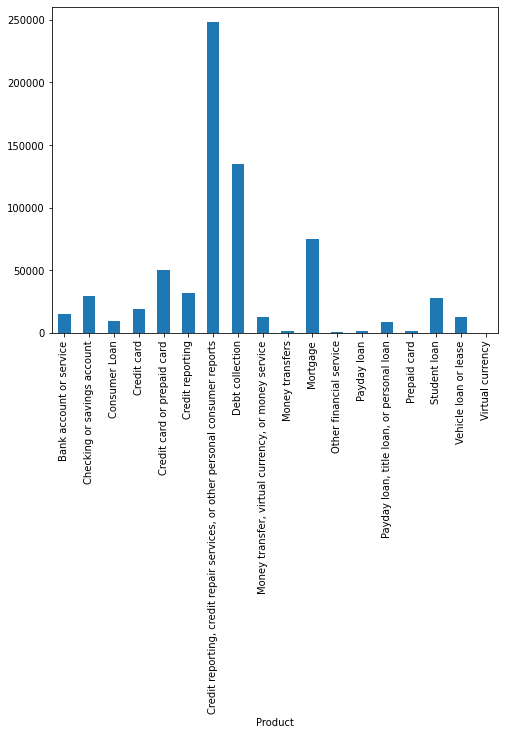

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

# Undersample the High Frequency Classes - Using Median Count

In [31]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    248115
Debt collection                                                                 134651
Mortgage                                                                         75042
Credit card or prepaid card                                                      50365
Credit reporting                                                                 31588
Checking or savings account                                                      29404
Student loan                                                                     27735
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               12994
Vehicle loan or lease                                                            12287
Consumer Loan                              

In [26]:
print('Minority Class Count : ', df['Product'].value_counts().min())
print('Majority Class Count : ', df['Product'].value_counts().max())

Minority Class Count :  16
Majority Class Count :  248115


In [27]:
# Percentage relative to the minority class
samplingStrategy = 0.005

In [28]:
import numpy as np

# Undersampling using sampling strategy 
nsamples_per_class = np.int16(df['Product'].value_counts().max()*samplingStrategy)
undersample = lambda df: df.loc[np.random.choice(a=df.index, size=min(len(df.index), nsamples_per_class), replace=False)]
df_bal = df.groupby(['Product'], as_index=False).apply(undersample)

print(df_bal.shape)

(20148, 3)


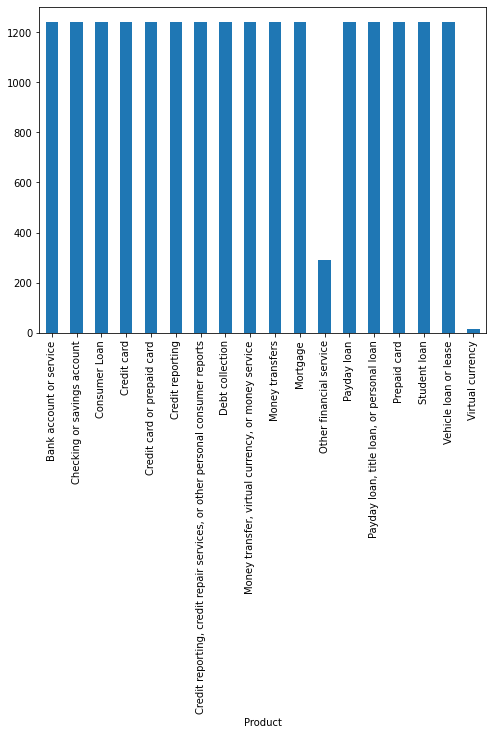

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_bal.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [33]:
df = df_bal

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(20148, 56099)

In [35]:
import sys
sys.getsizeof(features)/(1024**3)

5.960464477539063e-08

In [36]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])

  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  # Top N most correlated unigrams and bigrams for each category
  df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
  df_cat['Product'] = product
  df_cat['Unigrams'] = unigrams[-N:]
  df_cat['Bigrams'] = bigrams[-N:]
  
  df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [37]:
df_feat.head(20)

,Product,Unigrams,Bigrams
0,Bank account or service,citigold,checking account
1,Bank account or service,overdraft,overdraft fees
2,Checking or savings account,checking,savings account
3,Checking or savings account,bonus,checking account
4,Consumer Loan,vehicle,auto loan
5,Consumer Loan,car,car loan
6,Credit card,macy,annual fee
7,Credit card,card,credit card
8,Credit card or prepaid card,capital,comenity bank
9,Credit card or prepaid card,card,credit card


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [39]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [40]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


In [41]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,,Product,Consumer_complaint_narrative,category_id


In [42]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,,Product,Consumer_complaint_narrative,category_id


# Model Selection using Cross Validation

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

  print(model_name)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
LinearSVC
MultinomialNB


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


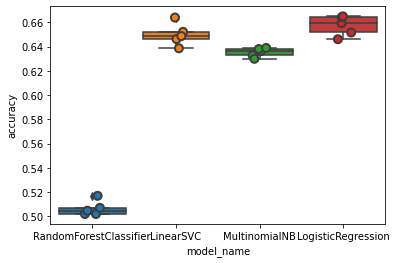

In [44]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [45]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.649891
LogisticRegression        0.657236
MultinomialNB             0.635150
RandomForestClassifier    0.506552
Name: accuracy, dtype: float64

# Baseline Classifiers

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

# Optimize Baseline Models Using GridSearchCV

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Multinomial Naive Bayes Classifier

In [47]:
# Implement the grid search
pipe = Pipeline([("vectorizer", CountVectorizer()), 
                 ("classifier", MultinomialNB())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__alpha':[1, 0.1]}

gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Multinomial Naive Bayes classifier  
gridCV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                   

In [48]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__alpha': 0.1, 'vectorizer__ngram_range': (1, 2)}
0.6137919016198994


In [49]:
# Evaluate the Multinomial Naive Bayes classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.48      0.53      0.51       288
                                                 Checking or savings account       0.57      0.57      0.57       332
                                                               Consumer Loan       0.44      0.33      0.38       287
                                                                 Credit card       0.53      0.52      0.53       291
                                                 Credit card or prepaid card       0.49      0.55      0.52       305
                                                            Credit reporting       0.57      0.66      0.61       320
Credit reporting, credit repair services, or other personal consumer reports       0.59      0.51      0.55       328
                                                       

## Logistic Regression Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', LogisticRegression())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__C':[0.5, 1],
          'classifier__penalty':['l2', None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Logistic Regression classifier
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

In [ ]:
# Evaluate the Logistic Regression classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

## Linear Support Vector Machine Classifier

In [51]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', LinearSVC())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__loss':['squared_hinge', 'hinge']}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Linear SVC classifier
gridCV.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                   

In [52]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__loss': 'squared_hinge', 'vectorizer__ngram_range': (1, 2)}
0.5603205777545327


In [53]:
# Evaluate the Linear SVC classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.46      0.45      0.46       288
                                                 Checking or savings account       0.55      0.46      0.50       332
                                                               Consumer Loan       0.35      0.32      0.33       287
                                                                 Credit card       0.48      0.49      0.48       291
                                                 Credit card or prepaid card       0.46      0.44      0.45       305
                                                            Credit reporting       0.56      0.62      0.59       320
Credit reporting, credit repair services, or other personal consumer reports       0.53      0.53      0.53       328
                                                       

## Random Forest Classifier

In [55]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', RandomForestClassifier())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__n_estimators':[50, 100],
          'classifier__max_depth':[2, 3],
          'classifier__random_state':[0, None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Random Forest classifier
gridCV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                   

In [56]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__random_state': 0, 'vectorizer__ngram_range': (1, 1)}
0.49672372827514977


In [57]:
# Evaluate the Random Forest classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.40      0.54      0.46       288
                                                 Checking or savings account       0.65      0.26      0.37       332
                                                               Consumer Loan       0.32      0.22      0.26       287
                                                                 Credit card       0.46      0.54      0.50       291
                                                 Credit card or prepaid card       0.42      0.30      0.35       305
                                                            Credit reporting       0.45      0.70      0.55       320
Credit reporting, credit repair services, or other personal consumer reports       0.43      0.27      0.33       328
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Best Model

In [58]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

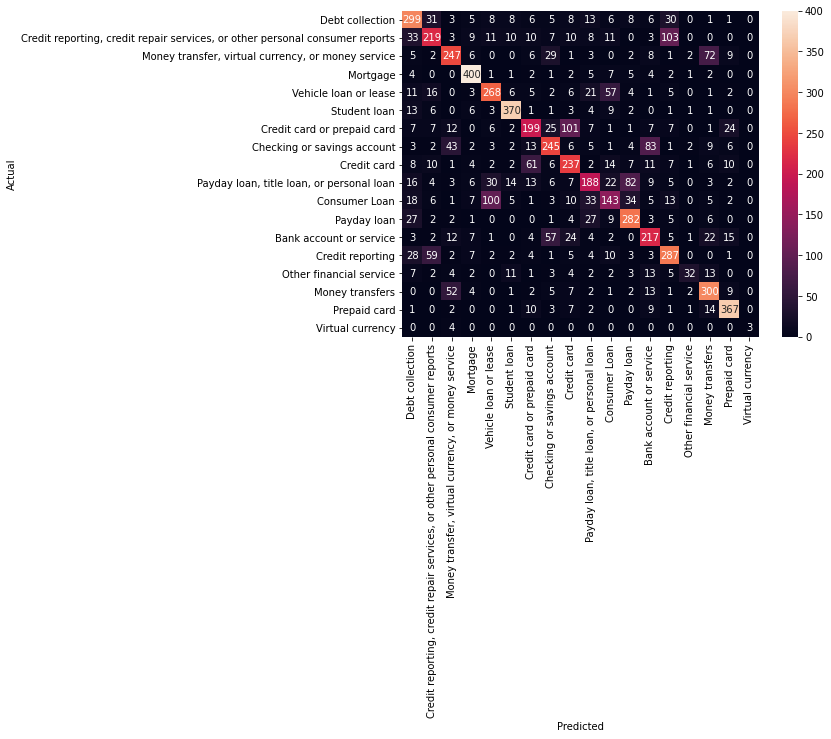

In [59]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [60]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 33 examples.


Product                       Consumer_complaint_narrative
6 939768   Credit reporting, credit repair services, or o...  I've been falsely accused of Suspicious Fraudu...
  1802374  Credit reporting, credit repair services, or o...  This account was deleted in XX/XX/2017 due to ...
  363719   Credit reporting, credit repair services, or o...  THE DISPUTED ACCOUNT LISTED HAS BEEN PAID FOR ...
  1917835  Credit reporting, credit repair services, or o...  I settled my account with Portfolio Recovery a...
  233617   Credit reporting, credit repair services, or o...  XXXX is reporting a debt on my file, and I no ...
  159203   Credit reporting, credit repair services, or o...  I open an account with XXXX in XXXX and it wen...
  373362   Credit reporting, credit repair services, or o...  I received a letter from the company in my pre...
  331219   Credit reporting, credit repair services, or o...  Mariner Finance is showing a collection debt o...
  897824   Credit reporting, credit repair services, or o...  According to the Fair Credit Reporting Act XXX...
  174809   Credit reporting, credit repair services, or o...  I have paid this account in full and when I tr...
  487675   Credit reporting, credit repair services, or o...  I sent a debt validation to equifax and the co...
  629871   Credit reporting, credit repair services, or o...  I have been attempting to get my credit report...
  65640    Credit reporting, credit repair services, or o...  XXXX XXXX Address : XXXX XXXX  XXXX City/ Stat...
  287716   Credit reporting, credit repair services, or o...  THE DISPUTED ACCOUNT HAS APPEARED ON MY CREDIT...
  577041   Credit reporting, credit repair services, or o...  I am a Victims of Identity Theft. I Never Auth...
  170893   Credit reporting, credit repair services, or o...  sent validation letters and called all credit ...
  91490    Credit reporting, credit repair services, or o...  My name is XXXX XXXX. In 2016 a debt was incur...
  363570   Credit reporting, credit repair services, or o...  THIS COMPANY XXXX XXXX XXXX. IS A FRAUD AND XX...
  268176   Credit reporting, credit repair services, or o...  On my credit report there is a collection acco...
  238169   Credit reporting, credit repair services, or o...  I have contact Equifax and have informed you t...
  1934858  Credit reporting, credit repair services, or o...  I checked my credit report today, XX/XX/2018 a...
  1903875  Credit reporting, credit repair services, or o...  On checking XXXX XXXX, XXXX XX/XX/2018, there ...
  273563   Credit reporting, credit repair services, or o...  Associated credit Services inc sent me two pie...
  16977    Credit reporting, credit repair services, or o...  After already submitting CFPB Complaint # XXXX...
  481609   Credit reporting, credit repair services, or o...  on XX/XX/2020, I called the creditor Nordstrom...
  216156   Credit reporting, credit repair services, or o...  On XX/XX/XXXX I had a company named MIDLAND CR...
  987600   Credit reporting, credit repair services, or o...  This account shown charge off in my credit rep...
  943815   Credit reporting, credit repair services, or o...  I am a victim of identity theft. I checked my ...
  111857   Credit reporting, credit repair services, or o...  XXXX XXXX accounts # XXXX and # XXXX are repor...
  277730   Credit reporting, credit repair services, or o...  XXXX/XXXX # XXXX is reporting a charge off to ...
  1953740  Credit reporting, credit repair services, or o...  The company has placed multiple delinquent not...
  674321   Credit reporting, credit repair services, or o...  Ive reviewed my credit report and happened to ...
  796004   Credit reporting, credit repair services, or o...  The account number listed on my credit report ...


'Vehicle loan or lease' predicted as 'Debt collection' : 11 examples.


Product                       Consumer_complaint_narrative
16 995804   Vehicle loan or lease  Automobile Acceptance Corporation & XXXX XXXX ...
   279761   Vehicle loan or lease  This debt is not mine someone else made this f...
   577842   Vehicle loan or lease  I sent Mercedes a 2nd Notarized Affidavit of T...
   926492   Vehicle loan or lease  I returned a XXXX XXXX XXXX in XX/XX/XXXX. The...
   655031   Vehicle loan or lease  This is in regards to " BMW FINANCIAL SERVICES...
   1796575  Vehicle loan or lease  I 've recently pulled my credit report and not...
   469533   Vehicle loan or lease  Santander informed me that this account was so...
   1019474  Vehicle loan or lease  BRIDGECREST FORMERLY XXXX  XXXX XXXX XXXX XXXX...
   1913450  Vehicle loan or lease  There was a change on my credit report with a ...
   909167   Vehicle loan or lease  I advised the company that I believe that I wa...
   332856   Vehicle loan or lease  On XX/XX/XXXX, I initiated a dispute in regard...


'Student loan' predicted as 'Debt collection' : 13 examples.


Product                       Consumer_complaint_narrative
15 1660757  Student loan  Navient 's collection service XXXX called me a...
   614      Student loan  Last Year around XXXX, I received a letter fro...
   760826   Student loan  American Education Services continues to make ...
   1724369  Student loan  I file this third complaint with the CFPB agai...
   1744095  Student loan  I XXXX XXXX claim that a company known as Nati...
   1719536  Student loan  There is a third party debt collection company...
   1727246  Student loan  Enterprise Recovery Systems called my employer...
   1644503  Student loan  Naivent representatives are repeatedly calling...
   1681285  Student loan  I HAVE TRIED TO CONTACT THE COMPANY FOR INFORM...
   974545   Student loan  I get an upwards of 8 to 10 phone calls every ...
   1668755  Student loan  In XXXX of 2016 I received a letter from a com...
   1998350  Student loan  ECMC on the behalf of its servicer XXXX will n...
   1837062  Student loan  On XX/XX/18 XXXX XXXX ( Account Manager ) on X...


'Credit card or prepaid card' predicted as 'Debt collection' : 7 examples.


Product                       Consumer_complaint_narrative
4 1879592  Credit card or prepaid card  I have asked Synchrony Bank for your JCPENNEY ...
  839864   Credit card or prepaid card  My husband and I found out we had our identiti...
  610202   Credit card or prepaid card  Hello. My name is XXXX XXXX and I have been ha...
  1961402  Credit card or prepaid card  XXXX, XXXX SOC SEC # XXXX DOB XX/XX/XXXX ADDRE...
  982060   Credit card or prepaid card  XX/XX/XXXX at approximately XXXX XXXX  central...
  73477    Credit card or prepaid card  I was diagnosed with XXXX XXXX XXXX and was to...
  1833893  Credit card or prepaid card  I am currently trying to clean up my credit re...


'Credit card' predicted as 'Debt collection' : 8 examples.


Product                       Consumer_complaint_narrative
3 1653381  Credit card  I 've requested debt Validtionfrom JH Portfoli...
  1726409  Credit card  Wal-Mart charged me {$500.00} when I opened th...
  1610816  Credit card  i got a letter from a collections agency today...
  1748172  Credit card  I had a credit card account with XXXX, but due...
  1782012  Credit card  I called to make a payment on my card today, a...
  1742029  Credit card  This debt is from 2007 and it has been 10 year...
  1710771  Credit card  My XXXX year old mother wanted to purchase a c...
  1730427  Credit card  I would like your assistance in obtain feedbac...


'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 16 examples.


Product                       Consumer_complaint_narrative
13 905129   Payday loan, title loan, or personal loan  XXXX XXXX has called my phone 4 times a day fo...
   203189   Payday loan, title loan, or personal loan  Someone used my name and got {$590.00}. At Che...
   927386   Payday loan, title loan, or personal loan  About three days ago a XXXX XXXX, Called me fr...
   1792617  Payday loan, title loan, or personal loan  The company states that I have n't payed them ...
   1946518  Payday loan, title loan, or personal loan  Please be on notice that I am submitting this ...
   1913287  Payday loan, title loan, or personal loan  XX/XX/XXXX, {$810.00}, I checked my credit rep...
   1865355  Payday loan, title loan, or personal loan  I used their service in XX/XX/XXXX or XX/XX/XX...
   795578   Payday loan, title loan, or personal loan  My loan was charged off by USAA back in 2016. ...
   962397   Payday loan, title loan, or personal loan  I keep getting phone calls at my job threateni...
   1006946  Payday loan, title loan, or personal loan  I have been struggling due to other debts and ...
   1798390  Payday loan, title loan, or personal loan  I received a telephone call from a company who...
   122349   Payday loan, title loan, or personal loan  Harassing mail and told wouldnt put this on my...
   684397   Payday loan, title loan, or personal loan  On XX/XX/XXXX, Capitol One financed a vehicle ...
   1852608  Payday loan, title loan, or personal loan  Hello ; Cashcall charged this debt off without...
   1841384  Payday loan, title loan, or personal loan  I have repeatedly asked XXXX XXXX XXXX to cont...
   856112   Payday loan, title loan, or personal loan  I received another call today including a prev...


'Consumer Loan' predicted as 'Debt collection' : 18 examples.


Product                       Consumer_complaint_narrative
2 1681038  Consumer Loan  I do n't exactly know how to reference this ac...
  1560627  Consumer Loan  First off my wife called to get pay off amount...
  1741607  Consumer Loan  I disputed with XXXX regarding a company that ...
  1650111  Consumer Loan  I originally took out a loan with XXXX XXXX XX...
  1736933  Consumer Loan  I currently have a debt to Springleaf Financia...
  1589798  Consumer Loan  it was a rent to own managed by XXXX al.we wer...
  1675905  Consumer Loan  Back in and around XX/XX/XXXX, My spouse and I...
  1736870  Consumer Loan  I asked for a workout plan and they were not w...
  1660625  Consumer Loan  Debt collector, Preformant Reco, telephone num...
  1629947  Consumer Loan  I would like to report CNAC, dba car now aacce...
  1611992  Consumer Loan  I 've repeatedly asked to have a letter sent s...
  1707004  Consumer Loan  I get calls every day from Midland collections...
  1609309  Consumer Loan  Continuation of complaint XXXX. We have reques...
  775060   Consumer Loan  I entered into a written contract with XXXX XX...
  1651456  Consumer Loan  My family and I have been receiving harassing ...
  1650418  Consumer Loan  I believe this company is operating a loan sca...
  1626364  Consumer Loan  I was a victim of a XXXX when the individual w...
  1781958  Consumer Loan  zenco collection company calling my place of e...


'Payday loan' predicted as 'Debt collection' : 27 examples.


Product                       Consumer_complaint_narrative
12 1784312  Payday loan  I received a phone call from the company and w...
   1610479  Payday loan  I contacted The Bureaus to pay off a debt. The...
   779346   Payday loan  I received a call today from a company stating...
   1688319  Payday loan  Opened an account with XXXX in XX/XX/XXXX. I f...
   1653265  Payday loan  A phone message was received by several people...
   1607814  Payday loan  I asked Greenback Recovery Group to stop calli...
   1699830  Payday loan  This company agreed to settle this usury inter...
   1699213  Payday loan  Should be marked as other. Mainly, Sands Recov...
   1700024  Payday loan  I keep receiving phone calls from people at a ...
   1063231  Payday loan  I 'm not really even sure who the original len...
   1161758  Payday loan                        Account was paid as agreed.
   1730809  Payday loan  last year i was something inaccurate on my cbr...
   1667549  Payday loan  Company XXXX is calling me, my family members,...
   1609985  Payday loan  A debt has been sold, original creditor is not...
   1786515  Payday loan  Marlette Funding , LLC showed up on my XXXX cr...
   1740156  Payday loan  Received notice from XXXX managment and paid {...
   1664110  Payday loan  XXXX XXXX president XXXX XXXX, and manager XXX...
   1652098  Payday loan  I took out a lone for {$1200.00} and I have pa...
   1616789  Payday loan  XX/XX/2012 my apartment was robbed. They stole...
   1729640  Payday loan  I received a call from a NP Group claiming I h...
   1670462  Payday loan  Someone from High Point Asset, Inc. called my ...
   1629983  Payday loan  I received a call at work on XXXX/XXXX/XXXX at...
   1650512  Payday loan  AD ASTRA RECOVERY SERVICES is an in-house coll...
   1693294  Payday loan  I received a letter stating that it was a XXXX...
   1706829  Payday loan  Unsolicited debt collection company called my ...
   1618401  Payday loan  the company added interest illegally and is st...
   777345   Payday loan  This old lender continues to sell old debt tha...


'Credit reporting' predicted as 'Debt collection' : 28 examples.


Product                       Consumer_complaint_narrative
5 1035844  Credit reporting  Ability Recovery Services has inserted this ac...
  1723108  Credit reporting  A company called XXXX has reported to Transuni...
  1784611  Credit reporting  To whom it may concern : My name is XXXX XXXX ...
  1628129  Credit reporting  XXXX XXXX, 2015XXXX : Request for Investigatio...
  1821905  Credit reporting  was contacted by collection agency proved debt...
  1060730  Credit reporting  The debt reported does not belong to me. The d...
  1709187  Credit reporting  I have contacted the collection agency XXXX XX...
  1743869  Credit reporting  The company never provide me with invoice to s...
  1726675  Credit reporting  XXXX XXXX XXXX has been trying to collect a de...
  1740734  Credit reporting  I have a account thats not not mine should be ...
  1704627  Credit reporting  These XXXX accounts are not mines. I have file...
  781170   Credit reporting  I have a collection on my credit report that h...
  1685587  Credit reporting  I have XXXX of debt reporting on my credit for...
  1712138  Credit reporting  There is item in collection on my credit repor...
  1740248  Credit reporting  On XXXX XXXX, XXXX I received a XXXX from " XX...
  1614605  Credit reporting  I dispute this debt belongs to me so I repeate...
  1687435  Credit reporting  There is a claim of a balance owed to XXXX. Th...
  1740831  Credit reporting  Did not receive verifiable proof ( an original...
  1694754  Credit reporting  XX/XX/XXXX-XX/XX/2011 I damaged my phone and r...
  1674821  Credit reporting  The original creditor sold this debt to a coll...
  1744253  Credit reporting  The company XXXX sold my account to a collecti...
  1739937  Credit reporting  There is a listing for a {$300.00} debt turned...
  1782115  Credit reporting  XXXX. \nACCOUNT # XXXX THIS IS A INVALD COLLEC...
  1662440  Credit reporting  This account was paid and closed by my employe...
  1726050  Credit reporting  The Creditor is seeking payment from me for a ...
  1601971  Credit reporting  Good Morning, I am reporting a creditor the XX...
  1686769  Credit reporting  In XXXX 2015 I received telephone call from a ...
  1640439  Credit reporting  I wrote and corresponded directly with XXXX an...


'Other financial service' predicted as 'Debt collection' : 7 examples.


Product                       Consumer_complaint_narrative
11 1629090  Other financial service  The cashier named XXXX XXXX, working in the Ch...
   1791655  Other financial service  As of XXXX XXXX I had repaid my debt with an e...
   1622268  Other financial service  I received a letter in the mail from Sofi or S...
   1647867  Other financial service  I was contacted by a representative and was to...
   1013096  Other financial service  Had an agreement with CheckCare Systems in  XX...
   1703084  Other financial service  I have just started with Clear One Advantage a...
   1700009  Other financial service  Calling me on my job and submitting personal i...


'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 31 examples.


Product                       Consumer_complaint_narrative
7 1879688  Debt collection       XX/XX/2014 XXXX Was not aware of the account
  378373   Debt collection  I have learned that Target is reporting to all...
  236471   Debt collection  This debt does not belong to me. I have filed ...
  1975398  Debt collection  In the months of XXXX, XXXX, XXXX, and XX/XX/2...
  282343   Debt collection  I was looking at my credit report and I found ...
  985749   Debt collection  XXXX XXXX, 2017 XXXX XXXX XXXX {$XXXX}. I had ...
  144924   Debt collection  The reporting is beyond the time allowed to be...
  361390   Debt collection  I AM VICTIM OF AN IDENTITY THEFT, AND WHT TAT ...
  781706   Debt collection  CRA VIOLATION NO KNOWLEDGE INACCURATE ACCOUNTS...
  652719   Debt collection  ENHANCED RECOVERY XXXX is violating my rights ...
  251483   Debt collection  In early XXXX, I received an alert that I had ...
  71403    Debt collection  Disputed this fraudulent credit item with XXXX...
  1027369  Debt collection  On XX/XX/2019 I mailed out a letter requesting...
  108550   Debt collection  Credit Management Opened XXXX XXXX, 2012 {$430...
  776363   Debt collection  I pulled all 3 of my credit reports, and my wi...
  27552    Debt collection  Please place an extended fraud alert on my cre...
  953733   Debt collection  This is a formal complaint against MERCHANTS &...
  1892514  Debt collection  XXXX XXXXXXXX XXXX XXXX is reporting a fraudul...
  1956165  Debt collection  I had had my identity stolen and I was ON XXXX...
  969282   Debt collection  I have tried to resolve this matter over and o...
  1659552  Debt collection  This bill was already paid by my insurance com...
  1010085  Debt collection  First Natl Bank of Omaha has violated 15 USC 1...
  371356   Debt collection  I recently obtained a copy of my credit report...
  241649   Debt collection  I received an email from XXXX ( my credit moni...
  159796   Debt collection  I, am a XXXX XXXX, this compant is saying that...
  649039   Debt collection  I am filing a complaint of non-compliance requ...
  1748835  Debt collection  There is an account on my credit report that i...
  1688608  Debt collection  I have been monitoring my credit report and sc...
  983998   Debt collection  I noticed a negative mark on my credit report ...
  1743576  Debt collection  They call me at all hours of the day and now u...
  149298   Debt collection  I HAVE 2 UNKNOWN COLLECTION ACCOUNTS ON MY CRE...


'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 16 examples.


Product                       Consumer_complaint_narrative
16 1849561  Vehicle loan or lease  Harley Davidson has been closed since 2017, fu...
   1840357  Vehicle loan or lease  I recently checked my credit and noticed that ...
   287720   Vehicle loan or lease  I'M A VICTIM OF IDENTITY THEFT. SOMEONE USED M...
   925820   Vehicle loan or lease  The account with XXXX XXXX XXXX XXXX in the am...
   826644   Vehicle loan or lease  This is regarding COASTAL CREDIT , LLC at XXXX...
   729469   Vehicle loan or lease  How are you doing during this pandemic? Hoping...
   605185   Vehicle loan or lease  I received a covid-19. Assistance differed pay...
   523934   Vehicle loan or lease  I tried calling the XXXX XXXX /Toyota Motors t...
   873473   Vehicle loan or lease  Santander was charged off and settled in XXXX....
   290250   Vehicle loan or lease  During these dates timeframes we went through ...
   534548   Vehicle loan or lease  bad warranty and balance on the original contr...
   9438     Vehicle loan or lease  When I reviewed my credit report I was shocked...
   563240   Vehicle loan or lease  Please reference prior CFPB complaint XXXX. De...
   1842406  Vehicle loan or lease  You have illegally attempted to run my credit ...
   1867143  Vehicle loan or lease  I was a victim of identity theft and submitted...
   1875405  Vehicle loan or lease  This item was already removed once. This compa...


'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 6 examples.


Product                       Consumer_complaint_narrative
15 1003935  Student loan  Contacted XXXX XXXX XXXX via mail, the first t...
   270180   Student loan  This request is in response to your tradeline ...
   866689   Student loan  Nelnet has been reporting negatively on my cre...
   1998298  Student loan  Im have financial difficulties at the moment a...
   185669   Student loan  In 2009 my purse was stolen and it contained a...
   500226   Student loan   My rights were violated pursuant to Federal Law.


'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 7 examples.


Product                       Consumer_complaint_narrative
4 890434   Credit card or prepaid card  I was trying to cancel a credit card on a home...
  126129   Credit card or prepaid card  I was the victim of a scam as a student at XXX...
  653778   Credit card or prepaid card  I have two credit different card accounts that...
  932010   Credit card or prepaid card  Based on the information stated in the letters...
  914312   Credit card or prepaid card  Sent first dispute letter out on XX/XX/XXXX it...
  1011578  Credit card or prepaid card  I paid on XX/XX/2018 {$25.00} for my XX/XX/201...
  943917   Credit card or prepaid card  On XX/XX/XXXX I made 3 separate payments to Sy...


'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 10 examples.


Product                       Consumer_complaint_narrative
3 1685934  Credit card  I am trying to update my address with Capital ...
  1784036  Credit card  Commentity Bank allowed someone to open an acc...
  1696178  Credit card  On XXXX XXXX, XXXX, I obtained a copy of my XX...
  1700790  Credit card  I am a victim of identity theft. \n\nA target ...
  1613811  Credit card  This company is in direct violation of 15 U.S....
  1731132  Credit card  After XXXX rounds of credit bureau disputing C...
  1736063  Credit card  THIS IS A HARD INQUIRIES ON MY CREDIT REPORT. ...
  1695875  Credit card  I reported to Macy 's that they were reporting...
  1069869  Credit card  In XX/XX/2015 I purchased my very first home. ...
  1688813  Credit card  On XXXX/XXXX/XXXX I look in to my credit repor...


'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 6 examples.


Product                       Consumer_complaint_narrative
2 1749248  Consumer Loan  FIFTH THIRD BANK-XXXX. XXXX XXXX XXXX MD XXXX,...
  1662298  Consumer Loan  Armed Forces Loans of Nevada I contacted them ...
  1613785  Consumer Loan  While reviewing my credit report, I see a cred...
  1725142  Consumer Loan  Capital One Auto Finance is reporting a reposs...
  1724083  Consumer Loan  I have disputed with the credit bureaus and Sa...
  1613451  Consumer Loan  WORLD FINANCE CORP. IS OVER THREE YEARS ACCOUN...


'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 59 examples.


Product                       Consumer_complaint_narrative
5 1616505  Credit reporting  After reviewing my credit report in detail XX/...
  1719601  Credit reporting  these hard inquiries are fraud on my credit re...
  1708600  Credit reporting  Equifax Information Services , LLC is purposel...
  771701   Credit reporting  I received a letter from Equifax on XXXX XXXX,...
  1726075  Credit reporting  XXXX of the creditors listed on my credit repo...
  1636139  Credit reporting  XXXX which is my current mortgage servicing co...
  1648163  Credit reporting  Experian refuses to remove the fraudulent acco...
  1582051  Credit reporting  I went to the bank to make a loan and become a...
  1674837  Credit reporting  I had a case of credit fraud in 2015 on severa...
  1641562  Credit reporting  Some of the Information Contained in my Consum...
  1629404  Credit reporting  This acct is not accurate on my report and is ...
  810195   Credit reporting  An erroneous credit inquiry was associated wit...
  1639620  Credit reporting  XXXX made an error on my credit report which h...
  1702666  Credit reporting  All credit bureaus have removed an open accoun...
  847761   Credit reporting  The company XXXX is reporting that I have an o...
  1589282  Credit reporting  There are XXXX inquires on my credit report th...
  1827634  Credit reporting  The company refuses to remove negative and ina...
  1585807  Credit reporting  Experian has allowed " XXXX XXXX " in reportin...
  1684071  Credit reporting  This account is not mine - an inadequate inves...
  842469   Credit reporting  I have been dealing with all XXXX credit burea...
  1624385  Credit reporting  Please be advised XXXX XXXX is reporting XXXX ...
  1680401  Credit reporting  No problems accessing XXXX or XXXX annual cred...
  1644179  Credit reporting  I have been working diligently over the last 6...
  1639649  Credit reporting  This account was removed from my credt report ...
  1701818  Credit reporting  I noticed on my check that only {$170.00} is b...
  923845   Credit reporting  I received a notice from XXXX that XXXX XXXX B...
  1667035  Credit reporting  I called Experian on XXXX/XXXX/16 to get inacc...
  1669667  Credit reporting  I have called Transunion several times and sen...
  1729876  Credit reporting  Received credit disclosure information from th...
  1690467  Credit reporting  My name is XXXX XXXX and I am writing to repor...
  774731   Credit reporting  Experian credit reporting company has re-inser...
  1735567  Credit reporting  Charge off Account with XXXX is not reporting ...
  1611485  Credit reporting  I have repeatedly sent correspondences to Expe...
  1035830  Credit reporting  I sent in a multiple inquiry removal letter on...
  1730093  Credit reporting  Information is missing from my credit report a...
  1722722  Credit reporting  XXXX XXXX MD, XXXX XXXX XXXX, XXXX XXXX, XXXX,...
  1987242  Credit reporting  Incoorect information is on my credit report a...
  1784118  Credit reporting  I have so many issues with this response, that...
  1758249  Credit reporting  Information Equifax is incorrect they deleted ...
  1795612  Credit reporting  I am a victim of identity theft and have some ...
  1686636  Credit reporting  i been dealing with this company not blocking ...
  1017755  Credit reporting  I have been trying to reach out to XXXX to und...
  1620940  Credit reporting  my dispute letters and explanations I filed wi...
  870955   Credit reporting  I have disputed two accounts with Equifax whic...
  1611584  Credit reporting  The issue is that XXXX, XXXX, and Transunion h...
  1691007  Credit reporting  Equifax is refusing to investigate and remove ...
  1692193  Credit reporting  Yes. I sent certified letters that got no resp...
  1677201  Credit reporting  Incorrect name and a address that I have never...
  1723876  Credit reporting  I was told by XXXX that, I have house which is...
  1701747  Credit reporting  My ex-husband filed for bankruptcy on XX/


'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 12 examples.


Product                       Consumer_complaint_narrative
4 156801   Credit card or prepaid card  How you doing i recently had ordered a new cas...
  228326   Credit card or prepaid card  in XX/XX/XXXX i cancelled a transaction for {X...
  358502   Credit card or prepaid card  On approximately XX/XX/2019, I purchased a car...
  408685   Credit card or prepaid card  Since XX/XX/XXXX, my Paypal accounts were clos...
  80470    Credit card or prepaid card  The Fidelity Investment Credit Card, provided ...
  1866695  Credit card or prepaid card  XXXX stores were in a lawsuit currently with t...
  50489    Credit card or prepaid card  On XX/XX/XXXX I went to XXXX XXXX with my chil...
  294126   Credit card or prepaid card  I purchased two tickets with XXXX XXXX using P...
  951635   Credit card or prepaid card  On XX/XX/XXXX, I made a {$330.00} payment to m...
  78533    Credit card or prepaid card  To Whom It May Concern, My XXXX Account was St...
  791410   Credit card or prepaid card  On XXXX XXXX, 2017, I went to the local branch...
  849993   Credit card or prepaid card  Neiman Marcus ( NM ) has disabled my log-in ac...


'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 43 examples.


Product                       Consumer_complaint_narrative
1 492713   Checking or savings account  I had a back payment of XXXX from VA unemploym...
  148700   Checking or savings account  I reported fraud and suspicious activity on my...
  886801   Checking or savings account  Good morning, You have an demand deposit accou...
  481939   Checking or savings account  today on XX/XX/XXXX i tried to log in into rob...
  679596   Checking or savings account  Bank of America will not close out my deceased...
  142181   Checking or savings account  I went on XXXX and saw a seller selling shoes....
  726487   Checking or savings account  Chime bank dispute claim id XXXX My mobile dev...
  825702   Checking or savings account  When filing my XXXX taxes my tax preparer incl...
  54213    Checking or savings account  XX/XX/2017 BANK OF AMERICA - I was a victim of...
  261641   Checking or savings account  I began the process of requesting the return o...
  938504   Checking or savings account  XXXX XXXX advertises the benefit of partnering...
  520588   Checking or savings account  When trying to connect the app XXXX to my Pnc ...
  178123   Checking or savings account  On XX/XX/2019 I incurred an unauthorized trans...
  544038   Checking or savings account  I r\n\nequested a few weeks ago to close my ch...
  752228   Checking or savings account  PNC Bank has blocked me from connecting my acc...
  1121058  Checking or savings account  Was victim to fraud via XXXX. Made complaint o...
  1935274  Checking or savings account  Some one from my PNC business checking account...
  411784   Checking or savings account  I'm trying to link my account with XXXX which ...
  124204   Checking or savings account  The following email was received on Friday, XX...
  1867691  Checking or savings account  On XX/XX/XXXX, I withdrew CAD {$60.00} from an...
  564868   Checking or savings account  They havent giving me my money I donated to XX...
  660839   Checking or savings account  I realized recently a fraudulent & sizable ( {...
  26757    Checking or savings account  Hi,I have been a PNC bank customer since XXXX,...
  298529   Checking or savings account  I've tried multiple times to link my PNC banki...
  705680   Checking or savings account  Tried several times to use my debit card to li...
  331742   Checking or savings account  I received one text notification of the first ...
  334724   Checking or savings account  I was contacted through XXXX  app regarding wo...
  692445   Checking or savings account  Not able to connect checking account to existi...
  944524   Checking or savings account      Unable to acess td bank from the XXXX account
  121419   Checking or savings account  Capital-One 360 : I sent {$1000.00} on XX/XX/1...
  901254   Checking or savings account  XXXX XXXX, XXXX, I had XXXX XXXX XXXX deposits...
  972647   Checking or savings account  Capital One restricted my account because they...
  331662   Checking or savings account    PNC wont allow me to find accounts such as XXXX
  69741    Checking or savings account  I am a XXXX year old woman who is nearing reti...
  45691    Checking or savings account  On XX/XX/2019 I requested a loan upon my reque...
  235879   Checking or savings account  Pnc isnt working with XXXX  so Im unable to li...
  1954733  Checking or savings account  Hello, I have been transferring money from my ...
  1019935  Checking or savings account  On XX/XX/2018 I sent a Lease payment to my lan...
  241627   Checking or savings account  I was XXXX on the XXXX the people who did it u...
  504896   Checking or savings account  My wife received unemployment benefits due to ...
  1021410  Checking or savings account  Hello Paypal Legal And Fraud Departments, Plea...
  507596   Checking or savings account  On Friday XX/XX/2020, I made several cash with...
  152058   Checking or savings account  I purchased 4 tickets through XXXX exchange. I...


'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 12 examples.


Product                       Consumer_complaint_narrative
0 1618011  Bank account or service  Deposited a cashiers check to Wells Fargo from...
  1721732  Bank account or service  Bank of America is holding an XXXX paycheck fo...
  1742112  Bank account or service  We had recently signed up with First Data to p...
  1644944  Bank account or service  I was informed XXXX certificates of deposits w...
  1692876  Bank account or service  CFPB Consumer Financial Protection Bureau Dear...
  1728781  Bank account or service  My name is XXXX XXXX. I have account with Ford...
  1694049  Bank account or service  My Paypal account had fraudulent activity, XXX...
  1716105  Bank account or service  The bank sent my money to the wrong account th...
  1639008  Bank account or service  On XXXX XXXX Bank of America foced closed my a...
  1705901  Bank account or service  I have a business checking account with PNC Ba...
  1748961  Bank account or service  i tried to draw XXXX dollars from it after inw...
  1742013  Bank account or service  Paypal is holding {$13000.00} of my available ...


'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 52 examples.


Product                       Consumer_complaint_narrative
9 1710956  Money transfers  HSBC Bank N.A Is always confiscating money tra...
  1629066  Money transfers  paypal has frozen my account, locked my funds ...
  1625466  Money transfers  My name is XXXX I live at XXXX XXXX XXXX XXXX ...
  1739171  Money transfers  My daughter requests her rent payment from me ...
  1634330  Money transfers  Hello, I order parts on XXXX XXXX and used XXX...
  1717908  Money transfers  Paypal continued to charge my credit card for ...
  1703720  Money transfers  I recently used Chase Quickpay to sell a pair ...
  1795922  Money transfers  I was notified b y Paypal o n  XXXX    XXXX   ...
  1686306  Money transfers  I was scammed online, and did not receive what...
  1064466  Money transfers  I purchased a pair tickets for myself and a fr...
  1742004  Money transfers  Funds were sent from my Venmo account erroneou...
  1658672  Money transfers  SUMMARY : I tried to provide a refund for an e...
  872353   Money transfers  Trying to purchase a radio from a person on XX...
  1722658  Money transfers  I received a {$2000.00} payment via Venmo. I s...
  1666454  Money transfers  I was asked If I was interested in making mone...
  1783975  Money transfers  I made a payment of {$100.00} to XXXX ( email ...
  1643642  Money transfers  paypal unilaterally deemed my account a " secu...
  1633746  Money transfers  PayPal has locked my account, i.e. refused acc...
  1686874  Money transfers  I noticed XXXX unauthorized charges were made ...
  1060526  Money transfers  I made a wire transfer on Saturday XX/XX/2017 ...
  1670762  Money transfers  I have a paypal account, with around XXXX doll...
  1773900  Money transfers  We XXXX bought a timeshare while on our honeym...
  1711149  Money transfers  My account with paypal was frozen and I have a...
  1696238  Money transfers  I submitted {$380.00} to an XXXX XXXX who clai...
  1637168  Money transfers  Subscription service was cancelled with mercha...
  1705925  Money transfers  Venmo refuses to provide me access to my funds...
  780073   Money transfers  I have received a payment of  XXXX   XXXX  fro...
  1667131  Money transfers  I tried to submit a payment via PayPal and I e...
  1658829  Money transfers  I got scammed using PayPal. I made a request o...
  862826   Money transfers  I have my international westernunion account w...
  878242   Money transfers  Paypal banned me for life because they say I v...
  1712906  Money transfers  PayPal is having a glitch where the available ...
  1676447  Money transfers  I was scammed by another Bank of America clien...
  1617152  Money transfers  I had sold an item ( Snap-on XXXX Portable Gas...
  1748297  Money transfers  I tried to close my Paypal account. PAYPAL sai...
  1649947  Money transfers  Paypal restricted my accts after i provided in...
  1065072  Money transfers  On XX/XX/2016 Paypal limited my account due to...
  1704344  Money transfers  Someone created a secondary bank account in my...
  1607866  Money transfers  while looking for employment I was approached ...
  1619771  Money transfers  Hello, I am a victim of a fraud for false vaca...
  1670924  Money transfers  NOT ABLE TO ACESS REFUNDS FROM FTC RULING AGAI...
  1664605  Money transfers  I have been banned from using MoneyGram. \n\nI...
  1642660  Money transfers  PayPal ( XXXX ) XXXX. is in breach of their ow...
  1994598  Money transfers  I opened an account with Skrill ( https : //ww...
  1663423  Money transfers  I paid XXXX XXXX of XXXX XXXX XXXX {$7000.00} ...
  1686271  Money transfers  On XX/XX/2016, i initiated a wire transfer fro...
  1675253  Money transfers  I made XXXX one-time purchases for digital pro...
  1718936  Money transfers  During many years I used to have several Paypa...
  1617153  Money transfers  This is about PayPal " Wallet ''. It allows cu...
  1629562  Money transfers  I have sent in total {$800.00} Venmo. Venmo ca...
  1558038  Money transfers  XXXX sells co


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 9 examples.


Product                       Consumer_complaint_narrative
6 214176   Credit reporting, credit repair services, or o...  On XX/XX/XXXX the divorce between my ex husban...
  1896022  Credit reporting, credit repair services, or o...  Rushmore Loan shows on my XXXX Credit Report t...
  59154    Credit reporting, credit repair services, or o...  Freedom Mortgage is refusing to update my info...
  176657   Credit reporting, credit repair services, or o...  My account ( # XXXX ) with Specialized Loan Se...
  924330   Credit reporting, credit repair services, or o...  XXXX XXXX is reporting late payments for the m...
  1989255  Credit reporting, credit repair services, or o...  I had a junior mortgage that was discharged ( ...
  273154   Credit reporting, credit repair services, or o...  I have had a mortgage loan with Wells Fargo si...
  22444    Credit reporting, credit repair services, or o...  I have a mortgage through Wells Fargo. I purch...
  256513   Credit reporting, credit repair services, or o...  back in XXXX on XXXX  i started to refinance m...


'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 6 examples.


Product                       Consumer_complaint_narrative
8 852687   Money transfer, virtual currency, or money ser...  Dear Consumer Financial Protection Bureau, Tod...
  154996   Money transfer, virtual currency, or money ser...  PayPal, which handles online financial transac...
  1805844  Money transfer, virtual currency, or money ser...  On XX/XX/XXXX, I made a {$10000.00} electronic...
  866771   Money transfer, virtual currency, or money ser...  I went to Wells Fargo Bank to wire my mortgage...
  930263   Money transfer, virtual currency, or money ser...  We are filing a complaint regarding a situatio...
  251101   Money transfer, virtual currency, or money ser...  I want to connect my account for a potential m...


'Student loan' predicted as 'Mortgage' : 6 examples.


Product                       Consumer_complaint_narrative
15 1923080  Student loan  I have sent numerous times and semt them certi...
   569408   Student loan  As per advise from the lender more tan 50 % lo...
   970609   Student loan  My XXXX has not been received in the mail and ...
   1834375  Student loan  I believe I'm bring improperly charged for int...
   1657444  Student loan  This is a letter that I sent to the companies ...
   895731   Student loan  I am in the process of trying to purchase a ho...


'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 6 examples.


Product                       Consumer_complaint_narrative
13 1715472  Payday loan, title loan, or personal loan  I have a home equity line of credit at Bank of...
   1841053  Payday loan, title loan, or personal loan  I have applied for a personal loan for XXXX do...
   656156   Payday loan, title loan, or personal loan  I purchased a home in XXXX of XXXX. I found th...
   903045   Payday loan, title loan, or personal loan  XXXX XXXX, 2017 - I forgot my password on my a...
   65153    Payday loan, title loan, or personal loan  I borrow a loan from beneficial it is amount o...
   985660   Payday loan, title loan, or personal loan  I received a SBA sponsored loan from Regions B...


'Consumer Loan' predicted as 'Mortgage' : 7 examples.


Product                       Consumer_complaint_narrative
2 1715380  Consumer Loan  I took out an auto loan through Wells Fargo on...
  1725095  Consumer Loan  i had a loan with green tree and now they say ...
  1610570  Consumer Loan  We purchased a home in 2002. When attempting t...
  773435   Consumer Loan  We bought a condo in texas-needed a line of cr...
  1653376  Consumer Loan  XX/XX/XXXX, I signed an authorization form for...
  1691441  Consumer Loan  I took out a HELOC loan against my primary res...
  1782626  Consumer Loan  On XXXX/XXXX/XXXX I filed a complaint against ...


'Bank account or service' predicted as 'Mortgage' : 7 examples.


Product                       Consumer_complaint_narrative
0 1644612  Bank account or service  I had an account with Nation 's Bank years ago...
  1681035  Bank account or service  Bank of America received funds from insurance ...
  1676061  Bank account or service  Last correspondence from Chase dated XXXX XXXX...
  1651778  Bank account or service  PROPERTY LOCATION : XXXX XXXX XXXX, CA XXXX WE...
  1647813  Bank account or service  Bank of America, : I had a mortgage account of...
  1711299  Bank account or service  I am currently a consumer of Bank of America p...
  1652059  Bank account or service  A Home Equity Loan that we have with Bank of A...


'Credit reporting' predicted as 'Mortgage' : 7 examples.


Product                       Consumer_complaint_narrative
5 1686991  Credit reporting  on several accounts, there is a mortgage liste...
  1633066  Credit reporting  I received my auto insurance policy renewal, a...
  1670313  Credit reporting  on several accounts, there is a mortgage liste...
  1697935  Credit reporting  I was reported by XXXX department stor being l...
  1616753  Credit reporting  XXXX is on my account twice, which the account...
  1720325  Credit reporting  I have asked TD Bank to remove mortgage inform...
  1730248  Credit reporting  My husband and I are in the middle of an FHA S...


'Debt collection' predicted as 'Vehicle loan or lease' : 8 examples.


Product                       Consumer_complaint_narrative
7 775296   Debt collection  On XX/XX/XXXX, I XXXX XXXX traveled to XXXX to...
  1748535  Debt collection  Received a letter months after moving ... neve...
  1966286  Debt collection  SRA Associates , Inc. and XXXX XXXX, XXXX are ...
  67294    Debt collection  To : Consumer Financial Protection Bureau. Thi...
  1643379  Debt collection  I called an requested a payoff and sent paymen...
  495700   Debt collection  I, XXXX XXXX, believes in the credit reporting...
  606528   Debt collection  On or approximately XX/XX/2020, I sent the com...
  47472    Debt collection  I rented a car from XXXX XXXX XXXX XXXX severa...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 11 examples.


Product                       Consumer_complaint_narrative
6 1916490  Credit reporting, credit repair services, or o...  My credit score continues not to increase no m...
  1032762  Credit reporting, credit repair services, or o...  I was the primary signer on two business vehic...
  540970   Credit reporting, credit repair services, or o...  I have an account with XXXX XXXX XXXX XXXX par...
  695088   Credit reporting, credit repair services, or o...  Making one final attempt for US Bank to do the...
  448725   Credit reporting, credit repair services, or o...  Back on XX/XX/XXXX I mailed disputes to the cr...
  478648   Credit reporting, credit repair services, or o...  I am contacting you about the compromising of ...
  994376   Credit reporting, credit repair services, or o...  XX/XX/XXXX I received a credit alert stating t...
  1877379  Credit reporting, credit repair services, or o...  I took out an auto loan on XX/XX/17 the car wa...
  62672    Credit reporting, credit repair services, or o...  Called all day to and everyday had called afte...
  459244   Credit reporting, credit repair services, or o...  I submit a FTC report to XXXX about a dozens o...
  795131   Credit reporting, credit repair services, or o...  The car reposession was removed off my credit ...


'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 6 examples.


Product                       Consumer_complaint_narrative
4 1967820  Credit card or prepaid card  I was alarmed once I reviewed my XXXX, XXXX  a...
  1892020  Credit card or prepaid card  I have a loan with BANK OF AMERICA. I have alw...
  1874333  Credit card or prepaid card  I have a loan with CAPITAL ONE. I have always ...
  601525   Credit card or prepaid card  Capital One bank has been promoting that it wi...
  459692   Credit card or prepaid card  I have a loan with SYNCB/GAP. I have always ma...
  893522   Credit card or prepaid card  I was shocked when I reviewed my credit report...


'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 30 examples.


Product                       Consumer_complaint_narrative
13 1012134  Payday loan, title loan, or personal loan  A Texas motor vehicle retail installment sales...
   263065   Payday loan, title loan, or personal loan  On XX/XX/2020, Approx. XXXX XXXX., 15 minutes ...
   77201    Payday loan, title loan, or personal loan  I got a loan from XXXX XXXX XXXX for {$5000.00...
   26157    Payday loan, title loan, or personal loan  I have a loan with Credit Acceptance, XXXX, Mi...
   91215    Payday loan, title loan, or personal loan  In XX/XX/2019 I had a water purification syste...
   1978106  Payday loan, title loan, or personal loan  I would like to bring to your attention someth...
   204837   Payday loan, title loan, or personal loan  We took a title loan on our XXXX XXXX last yea...
   1399636  Payday loan, title loan, or personal loan  XX/XX/XXXX , my l oan was brought fr om   XXXX...
   392338   Payday loan, title loan, or personal loan  The company has reported that I have not made ...
   15111    Payday loan, title loan, or personal loan  My son purchased a XXXX XXXX XXXX without a ti...
   664496   Payday loan, title loan, or personal loan  In XX/XX/2020 I paid off my loan ( account # X...
   234765   Payday loan, title loan, or personal loan  Loan Debt was fully paid but the company still...
   388194   Payday loan, title loan, or personal loan  When i signed this loan I was told my payments...
   918329   Payday loan, title loan, or personal loan  On XXXX XXXX I checked my XXXX XXXX account an...
   417809   Payday loan, title loan, or personal loan  On XX/XX/XXXX I attempted to pay off my auto l...
   351996   Payday loan, title loan, or personal loan  I finally was making payments on time after th...
   1803424  Payday loan, title loan, or personal loan  Honda Financial Services dba AHFC absconded my...
   980459   Payday loan, title loan, or personal loan  Seems my 1st payment was due on XX/XX/XXXX ......
   1973983  Payday loan, title loan, or personal loan  I leased a copier from XXXX XXXX XXXX XXXX XXX...
   73738    Payday loan, title loan, or personal loan  Had a Truck loan with Credit Acceptance Corpor...
   941128   Payday loan, title loan, or personal loan  I owed {$590.00} was not behind in payments an...
   400472   Payday loan, title loan, or personal loan  I have never been late, aside from postponing ...
   1926165  Payday loan, title loan, or personal loan  With purchase of a new vehicle I was swindled ...
   1003245  Payday loan, title loan, or personal loan  I made my first title payment late because it ...
   1861697  Payday loan, title loan, or personal loan  The account was charged off of with XXXX XXXX ...
   138940   Payday loan, title loan, or personal loan  I paid off my account with Conns on XXXX/XXXX/...
   592200   Payday loan, title loan, or personal loan  Went to get car fixed. The total in charges wa...
   388084   Payday loan, title loan, or personal loan  Today, XX/XX/XXXX I recieved my first bill whi...
   127940   Payday loan, title loan, or personal loan  ~Purchased a vehicle from XXXX XXXX , XXXX XX/...
   70062    Payday loan, title loan, or personal loan  While I couldn't make any payments on my vehic...


'Consumer Loan' predicted as 'Vehicle loan or lease' : 100 examples.


Product                       Consumer_complaint_narrative
2 1640674  Consumer Loan  On XXXX XXXX, 2015 we opened an auto loan with...
  1700194  Consumer Loan  I contacted Quality Acceptance LLC in Febuary ...
  1714834  Consumer Loan  XXXX XXXX I contacted cnac XXXX them know we n...
  1065248  Consumer Loan  NISSAN MOTOR ACCEPTANCE has sold this account ...
  1795136  Consumer Loan  I applied for an extension on   XXXX   XXXX  ....
...                  ...                                                ...
  1700022  Consumer Loan  I have had several phone calls rom bank of the...
  1585463  Consumer Loan  Approximately XX/XX/XXXX, I returned a vehicle...
  1686795  Consumer Loan  In XXXX XXXX, I returned a vehicle I had been ...
  1679347  Consumer Loan  I am contacting you at the XXXX time in order ...
  1325580  Consumer Loan  leased a XXXX VW jetta and several months late...

[100 rows x 2 columns]


'Debt collection' predicted as 'Student loan' : 8 examples.


Product                       Consumer_complaint_narrative
7 154443   Debt collection  You are the second person I am asking for help...
  1953330  Debt collection  I took out XXXX private student loans several ...
  1812753  Debt collection  XX/XX/XXXX I called XXXX to make payments on f...
  796598   Debt collection  My name is  XXXX   XXXX , I have had my federa...
  1947652  Debt collection  According to Federal student aid ( department ...
  1893000  Debt collection  XXXX - complaint # The feedback I received on ...
  1739229  Debt collection  Navient has contacted people outside of my dir...
  699947   Debt collection  Hello I have forwarded this email to my person...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 10 examples.


Product                       Consumer_complaint_narrative
6 613289   Credit reporting, credit repair services, or o...  XXXX had reissued a student loan listen to be ...
  930096   Credit reporting, credit repair services, or o...  Dates showing I missed payments when I was sti...
  1001454  Credit reporting, credit repair services, or o...  I have struggled to increase my Credit score f...
  229270   Credit reporting, credit repair services, or o...  Due to challenging financial circumstances, I ...
  922316   Credit reporting, credit repair services, or o...  I had a loan with national Collegiate Trust. i...
  1917731  Credit reporting, credit repair services, or o...  - In XXXX of XXXX I applied for a loan consoli...
  1405817  Credit reporting, credit repair services, or o...  On  XXXX   XXXX ,   XXXX   I was doing refinan...
  485249   Credit reporting, credit repair services, or o...  On XX/XX/2020, I contacted PennyMac Loans rega...
  795826   Credit reporting, credit repair services, or o...  I am nearly due to start paying back my loans ...
  86403    Credit reporting, credit repair services, or o...  We experienced a financial hardship after Hurr...


'Vehicle loan or lease' predicted as 'Student loan' : 6 examples.


Product                       Consumer_complaint_narrative
16 867541   Vehicle loan or lease  I called American Honda Finance on XX/XX/2017 ...
   884636   Vehicle loan or lease  I pay XXXX XXXX monthly for car payment and I ...
   1832506  Vehicle loan or lease  I paid a portion on my XX/XX/XXXX payment of {...
   154323   Vehicle loan or lease  I made a double payment in which one of the pa...
   508037   Vehicle loan or lease  On XX/XX/2020 at XXXX, I received a call from ...
   500753   Vehicle loan or lease  Yamaha Financial took back accounts for loans ...


'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 14 examples.


Product                       Consumer_complaint_narrative
13 1796841  Payday loan, title loan, or personal loan  I received a loan through this lender and even...
   449344   Payday loan, title loan, or personal loan  Good Afternoon, I am forced to file a complain...
   578529   Payday loan, title loan, or personal loan  Opp Loans, has failed to apply my loan payment...
   70114    Payday loan, title loan, or personal loan  Got a pay day loan from inbox loans on XX/XX/2...
   558908   Payday loan, title loan, or personal loan  I have not received a statement of my account ...
   196265   Payday loan, title loan, or personal loan  I called today because I received a letter abo...
   217690   Payday loan, title loan, or personal loan  HSBC was not allowing me to pay my loan over t...
   1397468  Payday loan, title loan, or personal loan  Please note this complaint is about being an i...
   77499    Payday loan, title loan, or personal loan  The initial loan taken out in Virginia was mad...
   74005    Payday loan, title loan, or personal loan  I was initially contacted by XXXX XXXX in Fall...
   937582   Payday loan, title loan, or personal loan  I have made over {$1600.00} worth of payments ...
   113812   Payday loan, title loan, or personal loan  I opened this loan in XXXX XXXX, KY XX/XX/XXXX...
   1847500  Payday loan, title loan, or personal loan  Nelnet Refuses To Mail Me A Paid In Full Lette...
   364203   Payday loan, title loan, or personal loan  I filed for bankruptcy, chapter XXXX, and it w...


'Other financial service' predicted as 'Student loan' : 11 examples.


Product                       Consumer_complaint_narrative
11 1829583  Other financial service  I saw an ad on Facebook that a friend posted s...
   1785187  Other financial service  Financial aid Services was the company that pr...
   1704291  Other financial service  Identity theft and a large sum of money stolen...
   1609079  Other financial service  In an attempt to pay down my student loans, th...
   1790485  Other financial service  I received a call from  XXXX   XXXX  of Premie...
   1782662  Other financial service  I was contacted as soon as I graduated in XXXX...
   1004689  Other financial service  I hired the company The Student Loan Help Cent...
   1680419  Other financial service  I was contacted by a company who claimed to be...
   1701900  Other financial service  I used a company called FedLoanhelp.org to red...
   1061808  Other financial service  I am a 2014 graduate of a XXXX program with ov...
   1795148  Other financial service  I attempted to contact Navient to discuss my s...


'Debt collection' predicted as 'Credit card or prepaid card' : 6 examples.


Product                       Consumer_complaint_narrative
7 1647801  Debt collection  Today I received a letter from Bank of America...
  401336   Debt collection  Called 27 times from XXXX. No information prov...
  1930965  Debt collection  I had an account with XXXX XXXX, I made one pu...
  1027196  Debt collection  To Whom it may concern : From XX/XX/2017 throu...
  1693028  Debt collection  A credit card was open under my name as a resu...
  1994570  Debt collection  I opened an account through XXXX XXXX XXXX wit...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 10 examples.


Product                       Consumer_complaint_narrative
6 1829119  Credit reporting, credit repair services, or o...  I applied for a XXXX XXXX and XXXX card on XX/...
  1865249  Credit reporting, credit repair services, or o...  I was shocked when I viewed my credit report a...
  180823   Credit reporting, credit repair services, or o...  This account is already PAID. I am seeing repe...
  572276   Credit reporting, credit repair services, or o...  I have two credit cards through XXXX. Around X...
  88219    Credit reporting, credit repair services, or o...  I have had a XXXX account since the year XX/XX...
  37156    Credit reporting, credit repair services, or o...  Barclays US closed my account in XX/XX/2018 wh...
  960052   Credit reporting, credit repair services, or o...  Capital One Bank has claimed that Account endi...
  233335   Credit reporting, credit repair services, or o...  PAYPAL sold my BUSSINESS PAYPAL CREDIT account...
  1932784  Credit reporting, credit repair services, or o...  After working so hard building my credits hist...
  426270   Credit reporting, credit repair services, or o...  Wells Fargo reported a credit card to my credi...


'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 6 examples.


Product                       Consumer_complaint_narrative
8 493145   Money transfer, virtual currency, or money ser...  I opened a dispute with PayPal on XX/XX/XXXX r...
  1370930  Money transfer, virtual currency, or money ser...  About a week ago, I contacted Paypal about my ...
  579388   Money transfer, virtual currency, or money ser...  Regarding Chase/AARP credit card # XXXX XXXX X...
  534397   Money transfer, virtual currency, or money ser...  Retained Paysafe Merchant services on XX/XX/20...
  134960   Money transfer, virtual currency, or money ser...  There was an unauthorized purchase {$1800.00} ...
  456064   Money transfer, virtual currency, or money ser...  To whom it may concern, I ( as an XXXX  ) tran...


'Checking or savings account' predicted as 'Credit card or prepaid card' : 13 examples.


Product                       Consumer_complaint_narrative
1 160368   Checking or savings account  On XX/XX/2019 at XXXX XXXX I paid my monthly p...
  1822578  Checking or savings account  I had a checking and a prepaid accounts with C...
  625320   Checking or savings account  I reported the card stolen and disputed each t...
  408559   Checking or savings account  I have been using cash apps direct deposit opt...
  575653   Checking or savings account  At the end of XXXX I was notified that XXXX ac...
  550816   Checking or savings account  On XX/XX/XXXX, I made agreed to a debit transa...
  334624   Checking or savings account  On XX/XX/2019 I contacted Discover Bank regard...
  139856   Checking or savings account  On XX/XX/XXXX, Discover closed my savings and ...
  144030   Checking or savings account  XXXX charged my bank account {$1100.00} instea...
  1922065  Checking or savings account  On XX/XX/XXXX, I placed a call to XXXX and spo...
  209893   Checking or savings account  On XX/XX/2020 I was charged XXXX by a Third pa...
  482909   Checking or savings account  The apple card doesnt allow for any customer a...
  941481   Checking or savings account  XXXX XXXX XXXX at XXXX XXXX XXXX XXXX XXXX a t...


'Credit card' predicted as 'Credit card or prepaid card' : 61 examples.


Product                       Consumer_complaint_narrative
3 1671585  Credit card  10+ years ago I submitted a request to permane...
  1634048  Credit card  On XXXX stmt. there was a late fee of XXXX. I ...
  1712688  Credit card  Bank Of America credit card web page allows re...
  1060801  Credit card  On XX/XX/2017, I opened a credit card with Cit...
  1794732  Credit card  I have been a customer o f Citi Bank Credit Ca...
...                ...                                                ...
  1651209  Credit card  I had a Wells Fargo VISA credit card for sever...
  1645784  Credit card  I had ordered tickets to a hockey event for XX...
  1737995  Credit card  Opened arrival plus account back in XX/XX/XXXX...
  1694164  Credit card  I applied for a Zales credit card, financed th...
  1615578  Credit card  I had a promotional balance with Best Buy. The...

[61 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 13 examples.


Product                       Consumer_complaint_narrative
13 201886   Payday loan, title loan, or personal loan  After hurricane Harvey in XX/XX/2017 I made a ...
   513252   Payday loan, title loan, or personal loan  ON XX/XX/2020, I CONTACTED XXXX XXXX XXXX ( NC...
   629692   Payday loan, title loan, or personal loan  I purchased a XXXX XXXX with XXXX XXXX issued ...
   877263   Payday loan, title loan, or personal loan  On or around XX/XX/XXXX, I visited a Store nam...
   142512   Payday loan, title loan, or personal loan  I opened two separate accounts with this compa...
   692189   Payday loan, title loan, or personal loan  Chase Card Services, closed my account for a s...
   296100   Payday loan, title loan, or personal loan  In XXXX of XXXX, I had to get a root canal. At...
   1959981  Payday loan, title loan, or personal loan  XX/XX/XXXX I had been informed not by letter, ...
   56891    Payday loan, title loan, or personal loan  XX/XX/XXXX I paid XXXX as the payoff amount of...
   172343   Payday loan, title loan, or personal loan  I have been an online customer for XXXX XXXX X...
   154338   Payday loan, title loan, or personal loan  I keep receiving offers to apply for loans. I ...
   917017   Payday loan, title loan, or personal loan  I purchased a central air conditioning unit fr...
   159766   Payday loan, title loan, or personal loan  I was on the phone with a citi manager represe...


'Prepaid card' predicted as 'Credit card or prepaid card' : 10 examples.


Product                       Consumer_complaint_narrative
14 1749472  Prepaid card  XXXX has discriminated against me by not letti...
   1684028  Prepaid card  My daughter gave me a Mastercard Debit Card ( ...
   1651133  Prepaid card  Received from my employer, XXXX XXXX, XXXX Fl ...
   1787134  Prepaid card  Oklahoma  Tax Commission giv es state refunds ...
   1746834  Prepaid card  Chase Bank has a card called XXXX I applied an...
   1664214  Prepaid card  My card was lost while on vacation and I tried...
   1665633  Prepaid card  I purchased a Blue Bird AMerican Express card ...
   1691002  Prepaid card  I received XXXX ( XXXX ) USBank Cash+ Bonus Re...
   1598181  Prepaid card  XX/XX/XXXX : Discovered multiple charges on my...
   1654135  Prepaid card  I paid a merchant for an item I never received...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 7 examples.


Product                       Consumer_complaint_narrative
6 826678  Credit reporting, credit repair services, or o...  Early Warning Services have failed to investig...
  471298  Credit reporting, credit repair services, or o...  XXXX XXXX i tried calling. I dont use XXXX  XX...
  142236  Credit reporting, credit repair services, or o...  Its not a dollar amount I looked on my XXXX XX...
  92621   Credit reporting, credit repair services, or o...  In XX/XX/2019, I spoke with the branch manager...
  573341  Credit reporting, credit repair services, or o...  I used XXXX XXXX  for a bit and closed the acc...
  969476  Credit reporting, credit repair services, or o...  On XX/XX/XXXX a joint account at XXXX XXXX 30 ...
  445338  Credit reporting, credit repair services, or o...  I am unable to find any documentation of any c...


'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 29 examples.


Product                       Consumer_complaint_narrative
8 823044   Money transfer, virtual currency, or money ser...  Hi, I contacted Everbank to have my CD from XX...
  848662   Money transfer, virtual currency, or money ser...  Bank of America is just so slow with transacti...
  242293   Money transfer, virtual currency, or money ser...  It was a classic bad check scam. I received an...
  1967550  Money transfer, virtual currency, or money ser...  I had a checking and savings account with bank...
  861675   Money transfer, virtual currency, or money ser...  On XX/XX/XXXX a scheduled withdraw by XXXX XXX...
  1919918  Money transfer, virtual currency, or money ser...  I've been attempting to link my debit card end...
  981754   Money transfer, virtual currency, or money ser...  On XX/XX/XXXX. I noticed my bank account drain...
  176634   Money transfer, virtual currency, or money ser...  I have a retirement account with Charles Schwa...
  381283   Money transfer, virtual currency, or money ser...  My checking account was hacked after our bank ...
  277848   Money transfer, virtual currency, or money ser...  I have called multiple times to rollover my 40...
  234045   Money transfer, virtual currency, or money ser...  On XX/XX/2020 I filed my federal and state tax...
  607935   Money transfer, virtual currency, or money ser...  I tried to upload a check on XX/XX/XXXX. it di...
  954162   Money transfer, virtual currency, or money ser...  On XX/XX/XXXX I went to the bank of course XXX...
  1914973  Money transfer, virtual currency, or money ser...  On XX/XX/2018 PayPal advised me that Id have a...
  926166   Money transfer, virtual currency, or money ser...  Hi this incident was happen when I was trying ...
  604726   Money transfer, virtual currency, or money ser...  On Thursday XX/XX/2020 at approximately XXXX I...
  557590   Money transfer, virtual currency, or money ser...  This is to file a complaint regarding a fraud ...
  108374   Money transfer, virtual currency, or money ser...  Hi I have both HSBC Checking and saving accoun...
  174678   Money transfer, virtual currency, or money ser...  I applied for a XXXX XXXX  position at the com...
  289581   Money transfer, virtual currency, or money ser...  Pnc will not allow linking between pnc account...
  223372   Money transfer, virtual currency, or money ser...  On XX/XX/2019 a man from Kentucky accessed my ...
  568801   Money transfer, virtual currency, or money ser...  On XX/XX/2020 at XXXX XXXX I tried to do a deb...
  524017   Money transfer, virtual currency, or money ser...  Step 1 What is this complaint about? \n\nFailu...
  983028   Money transfer, virtual currency, or money ser...  On XX/XX/2018 I wrote a personal check issued ...
  521168   Money transfer, virtual currency, or money ser...  After setting up a new account with XXXX XXXX,...
  711779   Money transfer, virtual currency, or money ser...  Date : XXXX Someone, by the name of XXXX XXXX,...
  1792008  Money transfer, virtual currency, or money ser...  This is a complaint about Bank of America Date...
  371842   Money transfer, virtual currency, or money ser...  I was lead to believe that I was going to crea...
  98810    Money transfer, virtual currency, or money ser...  XXXX XXXX XXXX XXXX had an OPEN LETTER OF CRED...


'Credit card or prepaid card' predicted as 'Checking or savings account' : 25 examples.


Product                       Consumer_complaint_narrative
4 712595   Credit card or prepaid card  XX/XX/21 XXXX ATM withdrawl {$500.00} XX/XX/21...
  1826183  Credit card or prepaid card  In response to Citibanks letter dated XX/XX/XX...
  975733   Credit card or prepaid card  Chase is not allowing me easy access to my acc...
  199950   Credit card or prepaid card  I made a payment to CITI of {$30.00} on XX/XX/...
  728424   Credit card or prepaid card  Hello, my name is XXXX XXXX. Between XX/XX/XXX...
  803668   Credit card or prepaid card  I was issued a  XXXX  card for my tax check to...
  205488   Credit card or prepaid card  The Company provided a Fraudulent statement li...
  584058   Credit card or prepaid card  On XX/XX/25 I received an email indicating my ...
  248688   Credit card or prepaid card  Debit card was used at a Casino on XX/XX/XXXX ...
  786224   Credit card or prepaid card  Purchased a treadmill from  XXXX  in  XX/XX/XX...
  928126   Credit card or prepaid card  Chase XXXX XXXX has reversed several alleged f...
  1822054  Credit card or prepaid card  I opened a Wells Fargo Platinum credit card wi...
  654485   Credit card or prepaid card  I disputed a charge for hotel reservation XX/X...
  1996309  Credit card or prepaid card  I expect full provisional credit, as I was tol...
  68858    Credit card or prepaid card  The complainant was shocked to hear that Wells...
  59501    Credit card or prepaid card  XX/XX/XXXX and XX/XX/XXXX XXXX $ each day was ...
  950302   Credit card or prepaid card  XXXX XXXX XXXX is not allowing a third party a...
  329088   Credit card or prepaid card  My wife and I informed Bank of America of an u...
  61787    Credit card or prepaid card  This is in reference to complaint XXXX which w...
  622941   Credit card or prepaid card  I have a XXXX XXXX Trust Fund with XXXX XXXX X...
  283710   Credit card or prepaid card  Bank of America Premium Rewards Credit Cards h...
  651656   Credit card or prepaid card  On XX/XX/2020 I was at home and i relieved a t...
  674033   Credit card or prepaid card  Hi my name is XXXX XXXX XXXX. I live at addres...
  351620   Credit card or prepaid card  I noticed my Chase Bank account had been used ...
  592993   Credit card or prepaid card  Consumer service card holder had the loadable ...


'Credit card' predicted as 'Checking or savings account' : 6 examples.


Product                       Consumer_complaint_narrative
3 1729315  Credit card  This situation is not over until I get paid, I...
  1720438  Credit card  I am filing this complaint against JP Morgan C...
  1674378  Credit card  XX/XX/XXXX, I had originally opened a credit c...
  1619017  Credit card  US Bank has charged unauthorized charges back ...
  1729223  Credit card  I have an XXXX credit rating and never missed ...
  1664763  Credit card  I paid the balance In full via telephone, and ...


'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 6 examples.


Product                       Consumer_complaint_narrative
13 174936  Payday loan, title loan, or personal loan  Access # XXXX I have noticed an unauthorized w...
   255997  Payday loan, title loan, or personal loan  Their personal online banking hosting area of ...
   682281  Payday loan, title loan, or personal loan  Ref : XXXX XXXX XXXX XXXX XXXX XXXX # XXXX XXX...
   665709  Payday loan, title loan, or personal loan  PA  business grant lender denied access to my ...
   970331  Payday loan, title loan, or personal loan  I told the lady I was filing a complaint and s...
   429763  Payday loan, title loan, or personal loan  1. XXXX XXXX XXXX XXXX applied through Bank of...


'Bank account or service' predicted as 'Checking or savings account' : 57 examples.


Product                       Consumer_complaint_narrative
0 1707715  Bank account or service  Chain of Events : First, I must state that I n...
  1688450  Bank account or service  I opened a checking account with Citibank and ...
  1742872  Bank account or service  It has now been 7 days past the deadline for C...
  1637076  Bank account or service  Dear CFPB, We are in the process of XXXX and a...
  1755820  Bank account or service  My debit card was stolen on XX/XX/2017 On that...
  842232   Bank account or service  Compass Bank Accessed a {$38.00} fee on XX/XX/...
  1739074  Bank account or service  I am stating my upmost disgust for American Ex...
  872765   Bank account or service  On XXXX XXXX, XXXX I continued to pursue the c...
  1620801  Bank account or service  Two transactions were posted after the service...
  1783135  Bank account or service  I opened a Citibank account XX/XX/XXXX using p...
  1712820  Bank account or service  Bank of America ( BofA ) has not honored a {$3...
  1713924  Bank account or service  Opened a Citibank account on XX/XX/2016 under ...
  1655319  Bank account or service  chase charged me {$34.00} NSF fees for a {$10....
  1661184  Bank account or service  I had several items hit my account this week, ...
  1551287  Bank account or service  On XX/XX/2017 my debit card was stolen and use...
  1748991  Bank account or service  Since XX/XX/XXXX I have received a promotional...
  1681056  Bank account or service  Bank of America once again held onto a check p...
  1665017  Bank account or service  Bank of America issued a new debit card withou...
  1704518  Bank account or service  My amount was overdraft .XXXX cents. They char...
  1645282  Bank account or service  Was denied a purchase using my debit card. No ...
  1647903  Bank account or service  Went to XXXX to open up a checking account, wa...
  1061527  Bank account or service  I opened a new HSBC checking account with {$35...
  1665443  Bank account or service  Hello. I am Citibank checking customer since X...
  1720291  Bank account or service  A merchant tried crediting me back for {$1500....
  1690119  Bank account or service  I have ally bank checking and savings account....
  1583127  Bank account or service  I have an account with Capital One 360 and hav...
  1673751  Bank account or service  I started a SunTrust bank checking account onl...
  1634689  Bank account or service  Early Warning is reporting a fraud situation c...
  1786675  Bank account or service  My husband XXXX and I are victims of debit car...
  1691996  Bank account or service  XXXX/XXXX/15 - TD Bank assessed a {$35.00} OD ...
  1639520  Bank account or service  I tried to open Santander Bank Checking accoun...
  1689869  Bank account or service  I have been a client of BB & T Bank for over 1...
  1627370  Bank account or service  Comerica has to be one of the WORST banks out ...
  1689548  Bank account or service  PNC had an account opening bonus for a checkin...
  1614624  Bank account or service  On XXXX XXXX I performed a mobile deposit of a...
  1657610  Bank account or service  My bank, Metro Bank, was purchased by First Na...
  853881   Bank account or service  XX/XX/XXXX, we visited Keybank regarding fees ...
  778374   Bank account or service  I signed up for  an HSBC Checking acc ount whi...
  1721789  Bank account or service  I have requested a copy of my statements for a...
  1749187  Bank account or service  I opened a business checking account at Fifth ...
  1617934  Bank account or service  Citizens Bank unlawful withdrew money from che...
  1677553  Bank account or service  A number of unauthorized debit charges were ma...
  1682876  Bank account or service  I have had a checking and savings account with...
  1701018  Bank account or service  Wells Fargo consistently changes the order of ...
  1747365  Bank account or service  During XXXX and XXXX I purchased items through...
  1758687  Bank account or service  I filed a complaint with the CFB ag


'Debt collection' predicted as 'Credit card' : 8 examples.


Product                       Consumer_complaint_narrative
7 1649561  Debt collection  I had a XXXX Card thier were some issues with ...
  911679   Debt collection  Capital one bank kept increased my credit card...
  1839991  Debt collection  I fell behind on my credit card payment. Capit...
  1847694  Debt collection  A MERCHANT IN THE INTERNET ADVERTISED A BEAUTY...
  922361   Debt collection  The company has contacted relatives about the ...
  282799   Debt collection  This company collection of Athens is a complet...
  1727587  Debt collection  I was sent a letter with a payment arrangement...
  187234   Debt collection  In XXXX, XXXX, I registered for a Citibank cre...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 10 examples.


Product                       Consumer_complaint_narrative
6 380327   Credit reporting, credit repair services, or o...  XXXX XXXX reported a balance that is incorrect...
  1929337  Credit reporting, credit repair services, or o...  keeps reporting information on a account that ...
  770417   Credit reporting, credit repair services, or o...  I contact the company Citibank in regards to a...
  1928857  Credit reporting, credit repair services, or o...  There is a business credit card that was taken...
  442346   Credit reporting, credit repair services, or o...  I have ask the for itemization of record from ...
  510541   Credit reporting, credit repair services, or o...  The current amount due on my XXXX XXXX XXXX Cr...
  884198   Credit reporting, credit repair services, or o...  I was solicited while on line with my XXXX acc...
  295701   Credit reporting, credit repair services, or o...  I am disputing Discover Card charge off report...
  664247   Credit reporting, credit repair services, or o...  Dear XXXX, Ive been a holder of a XXXX credit ...
  930341   Credit reporting, credit repair services, or o...  The original credit line of this card was XXXX...


'Vehicle loan or lease' predicted as 'Credit card' : 6 examples.


Product                       Consumer_complaint_narrative
16 837677   Vehicle loan or lease  About a year into the loan I went on the compa...
   978979   Vehicle loan or lease  Chase is trying to charge me a second late fee...
   496651   Vehicle loan or lease  The statements does not match of my payments. ...
   891529   Vehicle loan or lease  I feel no one is listening to me at Honda Fina...
   1366144  Vehicle loan or lease  I was shocked when I reviewed my credit report...
   784892   Vehicle loan or lease  I was shocked when I reviewed my credit report...


'Credit card or prepaid card' predicted as 'Credit card' : 101 examples.


Product                       Consumer_complaint_narrative
4 1788169  Credit card or prepaid card  I was shocked when I reviewed my credit report...
  820598   Credit card or prepaid card  This complaint is against American Express. I ...
  797734   Credit card or prepaid card  I need help in getting the written dispute pol...
  1204370  Credit card or prepaid card  I have had an American Express card since XXXX...
  518293   Credit card or prepaid card  Opened a secured credit card with discover car...
...                                ...                                                ...
  916205   Credit card or prepaid card  I became a customer of Synchrony Bank when I p...
  1903256  Credit card or prepaid card  I have a Visa credit card with Bank of America...
  1983691  Credit card or prepaid card  On XX/XX/XXXX, I filed complaint XXXX-XXXX  ab...
  1966629  Credit card or prepaid card  The XXXX XXXX XXXX managed by Barclays is the ...
  749092   Credit card or prepaid card  I applied for a Citi bank credit card And rece...

[101 rows x 2 columns]


'Checking or savings account' predicted as 'Credit card' : 6 examples.


Product                       Consumer_complaint_narrative
1 313422   Checking or savings account  Navy Federal closed my account to where I coul...
  516947   Checking or savings account  I have a few different reference numbers from ...
  64991    Checking or savings account  There are a number of Fraudulent charges on my...
  1368067  Checking or savings account  Wellsfargo wiped out my savings without my kno...
  1909793  Checking or savings account  Im due to unfortunate events I had a mishap wi...
  1011758  Checking or savings account  In XXXX of XXXX I attempted to open a new Disc...


'Payday loan, title loan, or personal loan' predicted as 'Credit card' : 7 examples.


Product                       Consumer_complaint_narrative
13 802309   Payday loan, title loan, or personal loan  I 've been usin  g PayPal for over 10 years so...
   994775   Payday loan, title loan, or personal loan  I have been contacting XXXX XXXX XXXX XXXX Cre...
   55787    Payday loan, title loan, or personal loan  I complained that this company was stealing mo...
   826978   Payday loan, title loan, or personal loan  Was never notified that Wells Fargo had decide...
   1011157  Payday loan, title loan, or personal loan  First, I am filing  XXXX  complaints. These  X...
   137086   Payday loan, title loan, or personal loan  HSBC decided that all customers would be force...
   490408   Payday loan, title loan, or personal loan  I have been a customer at Cash 1 for many year...


'Consumer Loan' predicted as 'Credit card' : 10 examples.


Product                       Consumer_complaint_narrative
2 772540   Consumer Loan  XXXXRegional Finance ( RF ) is placing a " For...
  1719200  Consumer Loan  I was shocked when I reviewed my credit report...
  1634956  Consumer Loan  I entered into a car loan with GoFinancial and...
  1706132  Consumer Loan  Citbank just took over for Brooks Brothers cre...
  1697591  Consumer Loan  I purchased furniture from XXXX in the summer ...
  1726904  Consumer Loan  Consumer Portfolio Services. The interest char...
  1671691  Consumer Loan  No credit line increase allowed, Synchrony Ban...
  1781145  Consumer Loan  I shopped at amazon did get a credit card from...
  1722906  Consumer Loan  I was unable to make the remaining payment to ...
  1639327  Consumer Loan  I applied to Discover personal loans for an in...


'Bank account or service' predicted as 'Credit card' : 24 examples.


Product                       Consumer_complaint_narrative
0 1612164  Bank account or service  Chase does not allow customers to set up repea...
  1719249  Bank account or service  I have authorized electronic/paperless deliver...
  1719991  Bank account or service  I applied for a credit card for my business wi...
  1588722  Bank account or service  It has been the longest while since I have had...
  1035034  Bank account or service  XX/XX/XXXX Dear Sir or Madam : This dispute re...
  1625144  Bank account or service  Bank of America closes an XXXX years old check...
  1647351  Bank account or service  XXXX XXXX, 2016. I got a letter from Wells Far...
  1688570  Bank account or service  Citibank breaches information. \nSince XXXX of...
  1703878  Bank account or service  Bank of America changed my account type from a...
  1691599  Bank account or service  Someone open up a merchant account ( credit ca...
  1746277  Bank account or service  XX/XX/XXXX I transitioned to a new job. My fin...
  1711064  Bank account or service  I would like to lodge a complaint against Sync...
  1668977  Bank account or service  I autopay my Citi credit card online and chang...
  1703948  Bank account or service  I filed a BankAmericard Cash Rewards Card toda...
  1595174  Bank account or service  I asked Navy Federal Credit Union to re-imburs...
  1724760  Bank account or service  Citibank decided on their own not to send me m...
  1630742  Bank account or service  my bank account was closed, and left me with d...
  771346   Bank account or service  On Saturday XXXX XXXX, 2016, I called the toll...
  1742256  Bank account or service  I received a letter from Polaris Home Funding ...
  1675549  Bank account or service  Chase accused me of fraud and closed my accoun...
  1665461  Bank account or service  complaint of double standard : I have over XXX...
  778162   Bank account or service  capital one credit card is not helping us and ...
  1715623  Bank account or service  I contacted US Bank to open up a dispute of XX...
  1618834  Bank account or service  Citi Bank credit card dispute department rever...


'Money transfers' predicted as 'Credit card' : 7 examples.


Product                       Consumer_complaint_narrative
9 773709   Money transfers  I have received around {$800.00} in overdraft ...
  1743189  Money transfers  We need Legal Forms For Constitional Laws Busi...
  1634290  Money transfers  I submitted my first Credit Card payment to XX...
  1732251  Money transfers  After cancelling my XXXX XXXX in XXXX of 2016,...
  774583   Money transfers  Electronic credit card payment was made from m...
  1620406  Money transfers  XXXX keep using unethically my credit card det...
  1669218  Money transfers  On XXXX XXXX, 2016 I issued an electronic paym...


'Prepaid card' predicted as 'Credit card' : 7 examples.


Product                       Consumer_complaint_narrative
14 1725397  Prepaid card  I disputed a transaction and provided complete...
   1615117  Prepaid card  I order an item and before I received the item...
   1630192  Prepaid card  I enrolled in Capital Ones so called secured c...
   1609486  Prepaid card  On or about XXXX XXXX, XXXX I contacted Capita...
   1742470  Prepaid card  I had a REDcard acct that I only used at XXXX ...
   1664207  Prepaid card  My account does not correctly show my actual b...
   1717003  Prepaid card  Hello, My name is XXXX XXXX. I am writing in r...


'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 13 examples.


Product                       Consumer_complaint_narrative
7 1776057  Debt collection  I was contacted by  Stallings Financial Group ...
  1671163  Debt collection  XXXX XXXX from Law office of Patenaude & Felix...
  1062318  Debt collection  On Friday, XX/XX/2016 at my place of employmen...
  479805   Debt collection  An agreement was made on XX/XX/2020 through ve...
  1993620  Debt collection  I made this personal loan with XXXX in GA, bac...
  121958   Debt collection  Went to mall and was enticed by sales person t...
  1886251  Debt collection  XXXX hired a 3rd Party to get people to switch...
  996933   Debt collection  In order for my cousin XXXX XXXX to received n...
  118724   Debt collection  on XX/XX/2019 a Loan company violated federal ...
  405441   Debt collection  Today XX/XX/2020 The debt collector called my ...
  156369   Debt collection  the date they have as the opening date of the ...
  750142   Debt collection  Hi! I had a membership to a fitness club back ...
  487300   Debt collection  I had previously requested that CU Recovery do...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 8 examples.


Product                       Consumer_complaint_narrative
6 330181   Credit reporting, credit repair services, or o...  I have a very old student loan about 14-16 yea...
  1933908  Credit reporting, credit repair services, or o...  XX/XX/2018 WENT TO XXXX XXXX IN XXXX XXXX, CA ...
  330189   Credit reporting, credit repair services, or o...  someone is using my Name without my permission...
  85089    Credit reporting, credit repair services, or o...  TransUnion has TWO entries ( of type 'Line of ...
  1864467  Credit reporting, credit repair services, or o...  On XX/XX/2017 XXXX gave me a hard pull which I...
  36427    Credit reporting, credit repair services, or o...  I have six credit card that are included in ba...
  1951345  Credit reporting, credit repair services, or o...  As to date the company has not corrected the i...
  324219   Credit reporting, credit repair services, or o...  On XX/XX/2020, I applied for a personal loan t...


'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 21 examples.


Product                       Consumer_complaint_narrative
16 650038   Vehicle loan or lease  I paid off my loan for a XXXX XXXX in XXXX. I ...
   1918259  Vehicle loan or lease  This is a complaint against PNC BANK. I am a v...
   474741   Vehicle loan or lease  Early XX/XX/2020, I received notification from...
   896574   Vehicle loan or lease  XXXX XXXX is knowingly accepting a fraudulent ...
   311762   Vehicle loan or lease  I took out a loan in XX/XX/2015 with XXXX/Sync...
   159858   Vehicle loan or lease  My husband and I voluntarily had our car repos...
   91832    Vehicle loan or lease  I have a car payment due on the XXXX of each m...
   302433   Vehicle loan or lease  Hello, I received a late payment alert on my c...
   433412   Vehicle loan or lease  I keep paying extra money and it keeps disappe...
   1947921  Vehicle loan or lease  I made a payment for XX/XX/XXXX on XX/XX/XXXX....
   367622   Vehicle loan or lease  Acura financial services was supposed to send ...
   714522   Vehicle loan or lease  This particular account situation that is late...
   759929   Vehicle loan or lease  My loan began  XXXX   XXXX  with a 42 month te...
   91051    Vehicle loan or lease  InXX/XX/2019I needed to submit a pay date chan...
   245412   Vehicle loan or lease  This particular account situation that is late...
   106134   Vehicle loan or lease  We sent a payoff loan check # XXXX and mailed ...
   1821416  Vehicle loan or lease  Dear sir My loan applied in XXXX XXXX - XXXX (...
   65009    Vehicle loan or lease  OnXX/XX/2017 Lobel Financial inc. without agre...
   314588   Vehicle loan or lease  TitleMax 's AutoCash has not release lien, whe...
   265929   Vehicle loan or lease  Please attached. This company is engaged is so...
   1900140  Vehicle loan or lease  On Monday XX/XX/2018 My wife and I called into...


'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 7 examples.


Product                       Consumer_complaint_narrative
4 240826   Credit card or prepaid card  I needed an increase in my credit line to make...
  21884    Credit card or prepaid card  On XX/XX/XXXX I submitted a price rewind reque...
  274757   Credit card or prepaid card  This particular account situation that is late...
  808129   Credit card or prepaid card  On Sunday,XX/XX/XXXX, I received a phone call ...
  1863355  Credit card or prepaid card  This is a complaint for credit card denial dat...
  290500   Credit card or prepaid card  American Express is failing to credit my accou...
  344786   Credit card or prepaid card  Went to pay my bill XX/XX/2020 on the app appr...


'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 33 examples.


Product                       Consumer_complaint_narrative
2 1736765  Consumer Loan  I am going through XXXX XXXX I have consolidat...
  1710770  Consumer Loan  I dispute that I authorized as a co-borrower o...
  1696773  Consumer Loan  Yes I have been with LOAN MAX for 2 years and ...
  1034674  Consumer Loan  I was approved for a personal loan for {$12000...
  1794092  Consumer Loan  In  XXXX   XXXX , I contacted Wilshire Consume...
  1607914  Consumer Loan  I notified, through email, NetCredit that I wa...
  1725361  Consumer Loan  Chase Financial after contacting several at XX...
  1681130  Consumer Loan  I have received an e-mail from a Prosper that ...
  773866   Consumer Loan  I purchased my vehicle XX/XX/XXXX. I started m...
  1716745  Consumer Loan  This debit has been wrote off my credit going ...
  1692416  Consumer Loan  After I filed a complaint with the Consumer Fi...
  1703888  Consumer Loan  I had a personal loan with Personal Finance Co...
  1593524  Consumer Loan  APR for this loan is XXXX -- -Finance charges ...
  1698211  Consumer Loan  I applied for a loan to improve my credit scor...
  1747620  Consumer Loan  About 12 years ago we took out a loan with XXX...
  1608172  Consumer Loan  I called usaa consumer credit for a personal l...
  1625796  Consumer Loan  Loan me sent a post card to my address with a ...
  1035824  Consumer Loan  Lending Club continues to send me " pre-approv...
  1066302  Consumer Loan  I wanted to pay off an existing installment lo...
  1748571  Consumer Loan  Took out a loan in XXXX of XXXX and I paid off...
  1744656  Consumer Loan  I currently have a personal loan with Wells Fa...
  775734   Consumer Loan  When meeting with a Consumer lawyer for anothe...
  1725726  Consumer Loan  As senior citizen and XXXX veteran who now is ...
  1717151  Consumer Loan  I contacted Titlemax of Texas d/b/a Titlemax t...
  1745421  Consumer Loan  This account should it be pay by the loan unem...
  1611998  Consumer Loan  I took out a loan for a ring that I purchased ...
  774668   Consumer Loan  I applied online for a loan with Rise Credit o...
  1615612  Consumer Loan  My loan company accessed my personal phone rec...
  1694611  Consumer Loan  Eagle Loan Company filed a judgement against m...
  1743774  Consumer Loan  On Tuesday XXXX XXXX I called an XXXX with a c...
  1752025  Consumer Loan  I revoked the authorization from the company t...
  1609458  Consumer Loan  I requested a increase on my {$250.00} line of...
  1671144  Consumer Loan  I took out a {$4000.00} loan with Springleaf F...


'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 27 examples.


Product                       Consumer_complaint_narrative
12 1749391  Payday loan  First of all, this form does not have a box to...
   1650198  Payday loan  Item XXXX ) First, The reason I am filing a Co...
   839993   Payday loan  XX/XX/2017 XXXX : I received a call from XXXX ...
   1625719  Payday loan  I took out a loan from them thinking it was le...
   1730687  Payday loan  I signed an on line contract for a XXXX loan (...
   1655538  Payday loan  I took out a loan for {$260.00} and had to pay...
   1617109  Payday loan  I received a loan from XXXX for XXXX in XXXX X...
   1656781  Payday loan  I told them I do n't get paid till Friday but ...
   1631863  Payday loan  I went in there on XX/XX/2015 and they gave me...
   1680791  Payday loan  I took a loan from cash call in XXXX 2014. Whe...
   771962   Payday loan  I made a loan with MyPayDayLoan.com. Shortly a...
   1671350  Payday loan  I borrowed XXXX was told my payoff fee total w...
   544635   Payday loan  CashMax loan that was paid for.Now a company i...
   1680488  Payday loan  I applied for a payday loan on XX/XX/XXXX from...
   1646645  Payday loan  I have gotten a with Radiant Cash for {$400.00...
   1702465  Payday loan  applied for loan with P N C financial, they re...
   1736945  Payday loan  Received a loan from CashCall. Was given a {$1...
   1724068  Payday loan  I borrowed XXXX and this company want {$4000.0...
   1746425  Payday loan  Over the course of the summer, I applied for a...
   1726708  Payday loan  Dear XXXX, It has come to my attention that pa...
   1037699  Payday loan  I was naive about the information I submitted ...
   1671347  Payday loan  I continued to get charged {$400.00} per month...
   1717892  Payday loan  I was issued a check from ez Corp. For a settl...
   1680249  Payday loan  A guy from Eloans sent me and email and said t...
   1725393  Payday loan  I took out a {$400.00} loan from XXXX to get s...
   1645601  Payday loan  They keep calling and harassing me and my exte...
   827892   Payday loan  I applied for a loan on XX/XX/XXXX. The loan w...


'Debt collection' predicted as 'Consumer Loan' : 6 examples.


Product                       Consumer_complaint_narrative
7 1741645  Debt collection  Good afternoon, I have received notifications ...
  672222   Debt collection  I recorded Regional Acceptance Corporation 's ...
  888999   Debt collection  Company phone XXXX I do not am not amessage se...
  1646197  Debt collection  Phone call made to brother with a message on a...
  1623966  Debt collection  My ex husband purchased a boat, but it was don...
  1632096  Debt collection  On XX/XX/2016 I received a call from someone w...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 11 examples.


Product                       Consumer_complaint_narrative
6 131997   Credit reporting, credit repair services, or o...  My credit report indicates a late payment for ...
  266825   Credit reporting, credit repair services, or o...  Requested documentation From Santander verifyi...
  1906107  Credit reporting, credit repair services, or o...  This company is not Metro 2 complaint in regar...
  1912399  Credit reporting, credit repair services, or o...  I went in to the dealership to discuss purchas...
  1437078  Credit reporting, credit repair services, or o...  I had a lease with  XXXX   XXXX   XXXX .   My ...
  480373   Credit reporting, credit repair services, or o...  Last Reported XX/XX/XXXX Creditor Name XXXX Ac...
  1825037  Credit reporting, credit repair services, or o...  This complain concerns that XXXX has reported ...
  551934   Credit reporting, credit repair services, or o...  I have contacted the credit agency and the com...
  859271   Credit reporting, credit repair services, or o...  My personal information, including location, s...
  519491   Credit reporting, credit repair services, or o...  To whom this may concern : I am filing this co...
  839585   Credit reporting, credit repair services, or o...  I have disputed this account many times every ...


'Mortgage' predicted as 'Consumer Loan' : 7 examples.


Product                       Consumer_complaint_narrative
10 838425   Mortgage  This is actually the second time I am contacti...
   1550789  Mortgage  Foreclosing during the appeal period. As well ...
   832912   Mortgage  I was told this was just a mistake, but it is ...
   1614830  Mortgage  I was shocked when I reviewed my credit report...
   1663458  Mortgage  Nationstar reported for a year on my credit th...
   1700523  Mortgage  they sent out a clean out crew XXXX times whil...
   859179   Mortgage  I was XXXX XXXX for XXXX years and separated. ...


'Vehicle loan or lease' predicted as 'Consumer Loan' : 57 examples.


Product                       Consumer_complaint_narrative
16 803939   Vehicle loan or lease  I purchased a  XXXX   XXXX  and the loan compa...
   821036   Vehicle loan or lease  I had bought a new XXXX XXXX XXXX in XXXX 2010...
   1372930  Vehicle loan or lease  I am financing a car with XXXX XXXX. In the ti...
   901894   Vehicle loan or lease  This is a follow-up to complaint XXXX. \n\nI a...
   941461   Vehicle loan or lease  I purchased a new vehicle, and utilized Bank o...
   668298   Vehicle loan or lease  I was recently informed that ALLY Financial ha...
   818778   Vehicle loan or lease  I obtained pre-approval for financing through ...
   789473   Vehicle loan or lease  Wells Fargo Dealer Services "  confirms that t...
   44027    Vehicle loan or lease  I had a 60 month loan with capital one I have ...
   779821   Vehicle loan or lease  I called Bank of America for a new car loan. I...
   1793105  Vehicle loan or lease  On XX/XX/XXXX I made 2 payment via XXXX bill p...
   528490   Vehicle loan or lease  I was tricked into this loan as the primary bo...
   1877401  Vehicle loan or lease  Purchased a new XXXX XXXX XXXX. Ford gives dis...
   705819   Vehicle loan or lease  Capital One does not have my account as paid o...
   93959    Vehicle loan or lease  I went to Carmax on XX/XX/XXXX and purchased a...
   458659   Vehicle loan or lease  Please note my chief complaint is misappropria...
   1997232  Vehicle loan or lease  I am a co-signer on this loan which is now in ...
   1018387  Vehicle loan or lease  Dear Sir or Ma'am, Please cfpb Identification ...
   114571   Vehicle loan or lease  My acct has perfect payment history except 4 p...
   790053   Vehicle loan or lease  On  XXXX   XXXX  i went to buy a new toyota   ...
   61890    Vehicle loan or lease  I was behind in my car payment in the amount o...
   1096203  Vehicle loan or lease  We have been restlessly attempting to resolve ...
   114553   Vehicle loan or lease  So, I just get a call from Wells Fargo which I...
   785464   Vehicle loan or lease  Drive Time is an National Buy here pay here ca...
   690504   Vehicle loan or lease  Ally Auto Finance.. i took out used car loan f...
   785581   Vehicle loan or lease  I le ased Honda ca r with American Honda Finan...
   829076   Vehicle loan or lease  We pay extra every month on a car loan that we...
   426132   Vehicle loan or lease  I was impacted severely by the current pandemi...
   1902912  Vehicle loan or lease  In mid XXXX my car was repossessed by XXXX XXX...
   1926160  Vehicle loan or lease  I filed bankruptcy in XXXX and all accounts we...
   1843172  Vehicle loan or lease  XX/XX/2015. XXXX XXXX  said I applied for a ca...
   1879220  Vehicle loan or lease  I HAVE CONTACTED US BANK NO LESS THAN 5 TIMES ...
   855221   Vehicle loan or lease  I was recently denied credit approval from Mer...
   1868071  Vehicle loan or lease  Santander Consumer USA does not provide refina...
   2877     Vehicle loan or lease  Navy Federal Credit Union raised my interest r...
   778195   Vehicle loan or lease  First and foremost, I must be honest and say I...
   1865639  Vehicle loan or lease  I have two auto loans with Ally, since XX/XX/X...
   936861   Vehicle loan or lease  I have a used 6 year auto loan ( account no. X...
   1916764  Vehicle loan or lease  We purchased a car and did not receive paperwo...
   836127   Vehicle loan or lease  This is an update with new information for a c...
   835183   Vehicle loan or lease  I paid $ 50k approximately for a used rental X...
   332317   Vehicle loan or lease  My name is XXXX XXXX and I purchased an auto f...
   919111   Vehicle loan or lease  On XX/XX/XXXX I made a payment on my car note ...
   330271   Vehicle loan or lease  I am being harassed by Credit Acceptance. I go...
   805224   Vehicle loan or lease  I received a Chase Auto Loan for a new car in ...
   782339   Vehicle loan or lease  I would avoid u sing Ally. Their return policy...
   387721   Vehicle loan or lea


'Student loan' predicted as 'Consumer Loan' : 9 examples.


Product                       Consumer_complaint_narrative
15 1782791  Student loan  I have been on deferment since 2015 but appare...
   115270   Student loan  I asked for a delay in payments. it was grante...
   1684984  Student loan  My son borrowed money for his college tuition ...
   1612007  Student loan  I do not receive statements/bills or any other...
   1700755  Student loan  I have asked that all correspondence be by mai...
   1679914  Student loan  promissory note loan per alabama FCRA statue 6...
   950922   Student loan  I was contacted XXXX/2016 stating that I had t...
   1691512  Student loan  The CEO of Discover Financial will not return ...
   1646038  Student loan  Loan amount started at one payment then the pa...


'Credit card' predicted as 'Consumer Loan' : 14 examples.


Product                       Consumer_complaint_narrative
3 1742227  Credit card  Refinanced some outstanding debt with a home e...
  1580973  Credit card  Received attached letter from Elan. Letter sta...
  1743027  Credit card  Paid the full balance due on the date the paym...
  1735489  Credit card  I have a Mastercard with USAA. USAA failed to ...
  1720050  Credit card  On XXXX/XXXX/16, I had a problem with my car s...
  1685226  Credit card  CONTACTED CHASE AFTER AN UN AGREED CHARGE AMOU...
  1727683  Credit card  Re : Synchrony Bank ( JC Penney account ). \nI...
  1613796  Credit card  I purchased a washer and dryer from H H Gregg....
  775144   Credit card  Capital One did not update my new address or p...
  1700414  Credit card  i have opened credit line with BOA since XXXX/...
  1633983  Credit card  I have had an account with Capital One since X...
  1717683  Credit card  I would like to file a formal complaint agains...
  1630709  Credit card  While making dinner on XXXX XXXX 2016, I recei...
  1758656  Credit card  I check my XXXX score on a monthly basis to ma...


'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 22 examples.


Product                       Consumer_complaint_narrative
13 655345   Payday loan, title loan, or personal loan  I am on fixed income, and not able to work. I ...
   69435    Payday loan, title loan, or personal loan  I took out a loan for {$8400.00} " around abou...
   1929757  Payday loan, title loan, or personal loan  Consumer reported a 30 day late to credit repo...
   1792565  Payday loan, title loan, or personal loan  I took out a title loan with Title Max in XXXX...
   784341   Payday loan, title loan, or personal loan  I had an installment loan wit h Conn 's that I...
   908137   Payday loan, title loan, or personal loan  I filed bankruptcy last year and the debt has ...
   795268   Payday loan, title loan, or personal loan  Constantly calling with short ANNOYING stateme...
   893543   Payday loan, title loan, or personal loan  I went into Chase bank on XXXX XXXX XXXX XXXX ...
   299898   Payday loan, title loan, or personal loan  Starting XX/XX/XXXX, I contacted the corporate...
   1796862  Payday loan, title loan, or personal loan  I am receiving collection calls from a third p...
   477418   Payday loan, title loan, or personal loan  XXXX is in violation of FDIC 5000 UNIFORM RETA...
   815822   Payday loan, title loan, or personal loan  Dear FCC or Consumer Financial Protection Agen...
   354368   Payday loan, title loan, or personal loan  I applied for a loan for XXXX XXXX XXXX  throu...
   77556    Payday loan, title loan, or personal loan  This complaint is about : XXXX XXXX XXXX XXXX ...
   200626   Payday loan, title loan, or personal loan  ON Saturday XX/XX/2020 I agreed to purchase a ...
   142806   Payday loan, title loan, or personal loan  This loan is listed as an auto loan. This is n...
   187021   Payday loan, title loan, or personal loan  On XX/XX/ 2019 I placed an online order for a ...
   119692   Payday loan, title loan, or personal loan  We had a XXXX representative sign us up for a ...
   1364204  Payday loan, title loan, or personal loan  Tammac Holdings Corp was paying  XXXX  a month...
   991134   Payday loan, title loan, or personal loan  About a year ago or little long I received a p...
   576406   Payday loan, title loan, or personal loan  RISE charged off my account, but an agreement ...
   884805   Payday loan, title loan, or personal loan  Hello, I have been requesting TD Autofinance t...


'Payday loan' predicted as 'Consumer Loan' : 9 examples.


Product                       Consumer_complaint_narrative
12 1705449  Payday loan  My issue started this morning when I received ...
   1655820  Payday loan  I continually receive offer letters that inclu...
   1749289  Payday loan  I took out an online loan with AVANT in the am...
   1742589  Payday loan  My matter is not a payday loan but I was instr...
   1676011  Payday loan  I have always paid on time and when I am going...
   1719741  Payday loan  This company is reporting an account that I ha...
   1734388  Payday loan  I received a loan from RISE credit, illegal in...
   772186   Payday loan  LoanMe is reporting erroneous late payments on...
   1668932  Payday loan  I got a loan back in XXXX of 2016 and I was ma...


'Credit reporting' predicted as 'Consumer Loan' : 10 examples.


Product                       Consumer_complaint_narrative
5 1712613  Credit reporting  I had voluntarily returned a vehicle to XXXX X...
  798129   Credit reporting  Monterey financial services was the loan compa...
  1671077  Credit reporting  Dear Sir/Madam I am writing you because I have...
  775271   Credit reporting  I am current on my credit cards and paying pay...
  1589490  Credit reporting  XXXX is the servicer of a now-closed XXXX cred...
  1737407  Credit reporting  I called them and they agreed to remove from m...
  1734273  Credit reporting  I was recently pre-approved for a car loan thr...
  1666847  Credit reporting  I do not have a credit score. I purchased car ...
  1740350  Credit reporting  I 'm XXXX years old. I have a full time steady...
  1746616  Credit reporting  I applied for a credit card with Best Buy to b...


'Debt collection' predicted as 'Payday loan' : 8 examples.


Product                       Consumer_complaint_narrative
7 1725945  Debt collection  to whom it may concern I am receiving telephon...
  1736739  Debt collection  I have been receiving calls from this collecti...
  1616558  Debt collection  My place of employment received a call from a ...
  1978008  Debt collection  Back in XX/XX/XXXX, my bank account was levied...
  1009531  Debt collection  XXXX XXXX XXXX is committing fraud by re-aging...
  1616000  Debt collection  Please see case number XXXX. I continue to get...
  1992100  Debt collection  I am sick with XXXX XXXX and XXXX XXXX. They u...
  10300    Debt collection  The accounts were open inXX/XX/2014. The amoun...


'Credit card' predicted as 'Payday loan' : 7 examples.


Product                       Consumer_complaint_narrative
3 1720771  Credit card  On XXXX, XXXX, 2016 I received a letter dated ...
  1675133  Credit card  I updated my email through the Kohls website a...
  1645302  Credit card  I was trying to place an order on Amazon and w...
  1707322  Credit card  XXXX charge automatically defaulted my billing...
  1704605  Credit card  Years ago I used my Bank of America card to ke...
  1724426  Credit card  American Express refuses to to listen to us ab...
  1621367  Credit card  i had scheduled a payment for my card but 5 da...


'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 82 examples.


Product                       Consumer_complaint_narrative
13 1796432  Payday loan, title loan, or personal loan  I contacted the loan places Im on XXXX XXXX th...
   41140    Payday loan, title loan, or personal loan  I took out a loan to pay electric which was sh...
   1904317  Payday loan, title loan, or personal loan  I am being harrassed on a daily basis. Company...
   841206   Payday loan, title loan, or personal loan  XXXXXXXXXXXX said my score has to be above 580...
   755868   Payday loan, title loan, or personal loan  On XX/XX/2020 someone using my personal info t...
...                                               ...                                                ...
   223685   Payday loan, title loan, or personal loan  I am unaware of when this loan was taken out. ...
   1997094  Payday loan, title loan, or personal loan  I applied for a payday loan in XXXX and was ap...
   840132   Payday loan, title loan, or personal loan  On XXXX-2017 My application for loan from Big ...
   874884   Payday loan, title loan, or personal loan  Mypaydayloan.com initiated a loan application ...
   1000754  Payday loan, title loan, or personal loan  In XX/XX/XXXX, I went to Speedy Cash at XXXX X...

[82 rows x 2 columns]


'Consumer Loan' predicted as 'Payday loan' : 34 examples.


Product                       Consumer_complaint_narrative
2 1796077  Consumer Loan  Cahnet USA is denying me their offering of pre...
  1748876  Consumer Loan  On XX/XX/XXXX2015 went to the branch in XXXX O...
  1677627  Consumer Loan  I received a marketing letter from Colonial Fi...
  1644430  Consumer Loan  My Loan Company is UAC, they call my Reference...
  1643377  Consumer Loan  When I negotiated terms of the loan repayment ...
  862244   Consumer Loan  I lost my job and was unable to pay the loan. ...
  1611009  Consumer Loan  I received a letter in the mail from Castle Pa...
  1698567  Consumer Loan  Went through a divorce was left to pay all bil...
  1635323  Consumer Loan  I contacted United Cash Loans by telephone to ...
  1743944  Consumer Loan  I had originally contacted XXXX XXXX, which I ...
  1714765  Consumer Loan  XX/XX/XXXX I took out an installment loan with...
  1638669  Consumer Loan  I had a XXXX credit line and have not been abl...
  1657191  Consumer Loan  universal acceptance corporation was asked not...
  1745177  Consumer Loan  Over the phone loan based on a " you qualify '...
  1787043  Consumer Loan  Out of sheer desperation I applied for a {$500...
  1742184  Consumer Loan  I went in to Advance America to obtain a loan ...
  1717981  Consumer Loan  I received a letter saying I qualified for a {...
  1746185  Consumer Loan  I took out an installment loan with Spotloan (...
  1637400  Consumer Loan  I purchaed a sofa from a local establishment {...
  774077   Consumer Loan  NetCredit is a company that take advantage of ...
  1671859  Consumer Loan  I got a loan from Spot Loan a few months ago a...
  1711714  Consumer Loan  I received an email approximately 3 weeks ago ...
  1736193  Consumer Loan  this company use to be castle payday loans now...
  1706147  Consumer Loan  Lender required last 4 of SSN for identificati...
  1727741  Consumer Loan  I knew the stipulations to taking out a instal...
  1591740  Consumer Loan  If I need to file bankruptcy, XXXX XXXX is the...
  1633292  Consumer Loan  XXXX XXXX XXXX, XXXX, FL BIG PICTURE LOANS Too...
  771612   Consumer Loan  I was contacted on XXXX XXXX, 2015 in regards ...
  773143   Consumer Loan  In XXXX, I needed additional cash, so I applie...
  1749156  Consumer Loan  The lender calls repeatedly each day although ...
  1734465  Consumer Loan  I have advised this company several times no c...
  1650092  Consumer Loan  I am currently in a financial hardship and I c...
  1628274  Consumer Loan  We bought a new Toyota, XXXX XXXX and were pre...
  1783062  Consumer Loan  In XX/XX/XXXX I tool out a payday loan with Ch...


'Debt collection' predicted as 'Bank account or service' : 6 examples.


Product                       Consumer_complaint_narrative
7 1031863  Debt collection  I terminated my XXXX XXXX service XX/XX/2016 d...
  115561   Debt collection  This is a credit card debt that is from XX/XX/...
  821244   Debt collection  HSBC has been a horrible lender and they have ...
  1729468  Debt collection  I have not called them yet for I just looked i...
  265365   Debt collection  A fraudulent Wells Fargo account was opened in...
  1693656  Debt collection  XXXX XXXX XXXX, XXXX. XXXX XXXX. XXXX XXXX, XX...


'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 8 examples.


Product                       Consumer_complaint_narrative
8 1991710  Money transfer, virtual currency, or money ser...  I use a Chase ATM card to withdraw cash from A...
  804172   Money transfer, virtual currency, or money ser...  I received a check for amount of {$6000.00} fr...
  346535   Money transfer, virtual currency, or money ser...  I was sent {$11000.00} around XXXX. I cant get...
  1913953  Money transfer, virtual currency, or money ser...  {$180.00} dollars was stolen from my account w...
  101906   Money transfer, virtual currency, or money ser...  Hello again, in this complaint I will include ...
  362080   Money transfer, virtual currency, or money ser...  YOUR ABOVE SELECTION CHOICES DID NOT PRETAIN T...
  244387   Money transfer, virtual currency, or money ser...  I was contacted by XXXX in regards to a job wi...
  684563   Money transfer, virtual currency, or money ser...  I urgently require a Cheque book but PNC bank ...


'Credit card or prepaid card' predicted as 'Bank account or service' : 7 examples.


Product                       Consumer_complaint_narrative
4 36052    Credit card or prepaid card  Synchrony Bank claims to be calls just about e...
  625088   Credit card or prepaid card  My ex-girlfriend had filed for Bankruptcy earl...
  1012468  Credit card or prepaid card  As an American citizen, tax payer, voter, cust...
  355752   Credit card or prepaid card  I requested to cancel my account and I was tol...
  1959924  Credit card or prepaid card  On XX/XX/XXXX, I submitted a request to Navy F...
  347624   Credit card or prepaid card  I tried a website to get an answer on a comput...
  908065   Credit card or prepaid card  Since Capital One took over XXXX XXXX I can no...


'Checking or savings account' predicted as 'Bank account or service' : 83 examples.


Product                       Consumer_complaint_narrative
1 52114    Checking or savings account  on XX/XX/XXXX I authorized the Internal Revenu...
  709383   Checking or savings account  This relates to a previous complaint : XXXX. I...
  1873411  Checking or savings account  On or about XX/XX/XXXX, I realized that my che...
  127084   Checking or savings account  On XXXX someone made a purchase using my debit...
  80709    Checking or savings account  My checking account was overdrawn without my k...
...                                ...                                                ...
  546196   Checking or savings account  We deposited a check for {$1700.00} on Friday ...
  991095   Checking or savings account  I am a former customer of Bank of America. Dur...
  787058   Checking or savings account  Wells Fargo has opened a checking and a saving...
  1854690  Checking or savings account  I've been charged more than 600.00 in overdraf...
  556765   Checking or savings account  On XX/XX/XXXX, I notice that {$28.00} was miss...

[83 rows x 2 columns]


'Credit card' predicted as 'Bank account or service' : 11 examples.


Product                       Consumer_complaint_narrative
3 1671326  Credit card  My Mother-In-Law is XXXX after a XXXX and the ...
  1689175  Credit card  We recently experience credit card discriminat...
  1691593  Credit card  I opened a credit card account with BBVA Compa...
  1744663  Credit card  I was living temporarily at the US and I had t...
  1619468  Credit card  My target card had autopay linked to an old ba...
  1638010  Credit card  I am a XXXX required to use my Government XXXX...
  1748336  Credit card  On XXXX XXXX, XXXXThe Office of the Comptrolle...
  1116945  Credit card  I have a credit card with Chase. My account wa...
  1675810  Credit card  Synchrony Bank ( Formerly GE Capital Retail Ba...
  1696896  Credit card  Bank suspended online access claiming fraud, h...
  1627455  Credit card  This company closed my account in XXXX 2015. T...


'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 9 examples.


Product                       Consumer_complaint_narrative
13 1061304  Payday loan, title loan, or personal loan  About XX/XX/XXXX, I had my business account wi...
   565574   Payday loan, title loan, or personal loan  Hi I'm a XXXX Veteran i have been a member of ...
   541431   Payday loan, title loan, or personal loan  Im writing to you to see if your agency would ...
   957524   Payday loan, title loan, or personal loan  I am a single mom with a mortgage payment, car...
   857879   Payday loan, title loan, or personal loan               I ca n't get any of my personal info
   980402   Payday loan, title loan, or personal loan  My checking Line of Credit product is overdraw...
   170306   Payday loan, title loan, or personal loan  I payed off an Equity Line of Credit with Key ...
   1860205  Payday loan, title loan, or personal loan             This account is an fraudulent account.
   447739   Payday loan, title loan, or personal loan  I applied for a person loan with Wells Fargo a...


'Other financial service' predicted as 'Bank account or service' : 13 examples.


Product                       Consumer_complaint_narrative
11 1599016  Other financial service  My payroll check was stolen and cashed by a th...
   1681610  Other financial service  I cashed a check written on a jp mogan check a...
   1663866  Other financial service  The reason I am asking for help is because : e...
   1607596  Other financial service  my account on social security was changed to W...
   1635495  Other financial service  Received a check from a customer of mine. Thei...
   1642341  Other financial service  I wanted to write and voice a concern involvin...
   1698786  Other financial service  I had my purse stolen a month ago. After immed...
   772754   Other financial service  Hi, the reason I am asking for help is because...
   1629230  Other financial service  I have banked with Bank of Oklahoma for almost...
   1684802  Other financial service  I order an item on XXXX, attempted to pay it w...
   1703660  Other financial service  On XXXX/XXXX/2015 at about XXXX I tried to use...
   1612928  Other financial service  On XXXX XXXX, 2016, I went to the Bank of Amer...
   1653972  Other financial service  I was pointed towards XXXX XXXX by my Bank XXX...


'Money transfers' predicted as 'Bank account or service' : 13 examples.


Product                       Consumer_complaint_narrative
9 1611803  Money transfers  On XXXX XXXX, 2016, I walked into the Wells Fa...
  1720695  Money transfers  I applied the wiretransfer by XXXX from US to ...
  1691023  Money transfers  hello i am in the process of registering a com...
  1747105  Money transfers  Back in the spring we experienced major delays...
  1726474  Money transfers  I have XXXX accounts at Citizens Bank NA. I re...
  1697421  Money transfers  Charles Schwab ( brokerage ) illegally took {$...
  1622815  Money transfers  On XXXX XXXX, 2015, I was scammed by XXXX peop...
  1646151  Money transfers  On Friday XXXX XXXX, 2015, I spoke to a repres...
  1651090  Money transfers  On XXXX XXXX, 2016, I received a call from the...
  1742796  Money transfers  Issued a wire transfer recall. The receiving b...
  1648625  Money transfers  On XX/XX/XXXX I went to a Bank of America ( Bo...
  1678963  Money transfers  My husband sent me a check in the mail using t...
  1706216  Money transfers  Hello, Upon reviewing my XXXX XXXX business ch...


'Prepaid card' predicted as 'Bank account or service' : 9 examples.


Product                       Consumer_complaint_narrative
14 1632670  Prepaid card  Wells Fargo has repeatly taken money out of my...
   771926   Prepaid card  assessed automated fee without sufficient disc...
   1625807  Prepaid card  My account got locked because the company chan...
   1732799  Prepaid card  I have several Savings, Checking, Trust accoun...
   1727427  Prepaid card  Closed and pulled money from the account to ma...
   1655241  Prepaid card  FIRST I received my deposit late then the next...
   1570249  Prepaid card  I receive monthly stipend for being a XXXX via...
   1618505  Prepaid card          Will discuss upon receiving notification.
   1610485  Prepaid card  I purchased XXXX Regions Now cards and they we...


'Debt collection' predicted as 'Credit reporting' : 30 examples.


Product                       Consumer_complaint_narrative
7 1699876  Debt collection  The company Monterey Financial has continued w...
  1672796  Debt collection  Collector : JEFFERSON CAPITAL SYSTEM Creditor ...
  160247   Debt collection  My identity was stolen and electric accounts h...
  905238   Debt collection  the company is a debt buyer.XXXX XXXX in 2015 ...
  1037194  Debt collection  I 've called & tried to request an invoice and...
  781512   Debt collection  This is a old bill like 20 years ago can you p...
  1782058  Debt collection  In XX/XX/2016 I recieved a phone call from Key...
  1719857  Debt collection  it was n't opened by me and they still have it...
  282097   Debt collection  I filed a dispute to XXXX  regarding ambulator...
  789960   Debt collection  American Express has violated 15 USC 1692 by c...
  1733066  Debt collection  THIS ACCOUNT IS NOT MINE IT IS A RESULT FROM M...
  664092   Debt collection  This Items been removed months ago & the debt ...
  179318   Debt collection  I never received a bill for the medical debt. ...
  1168365  Debt collection  On XX/XX/2016, I was on vacation in Florida wi...
  769012   Debt collection  I have filed a dispute through XXXX XXXX XXXX....
  1665224  Debt collection  There are two separate issues that are worthy ...
  1803810  Debt collection  On XXXX XXXX I checked my credit and noticed f...
  855625   Debt collection  I ran my credit report XXXX 2017 as I am attem...
  358834   Debt collection  I first learned about this when it showed up o...
  1688722  Debt collection  Bull City Financial falsely reported XXXX medi...
  1685126  Debt collection  this is a XXXX claim. i never received any inf...
  1873937  Debt collection  I fell behind on HOA payments for several mont...
  1619659  Debt collection  I do not own this account. It is indicating a ...
  995497   Debt collection  I have applied for a mortgage loan with the XX...
  1732107  Debt collection  I contacted XXXX, XXXX and XXXX in XXXX 2014 a...
  69524    Debt collection  XXXX XXXX/transunion per Transunion credit rep...
  1954035  Debt collection  Already disputed on XXXX  Credit and it was re...
  1724550  Debt collection  XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
  877971   Debt collection  Grant and Weber has failed to validate this de...
  1621130  Debt collection  Please see attached letter to the " Bureau of ...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 103 examples.


Product                       Consumer_complaint_narrative
6 573747   Credit reporting, credit repair services, or o...  To whom it may concern, My name is XXXX XXXX X...
  290058   Credit reporting, credit repair services, or o...  Experian has failed to send dispute results an...
  348594   Credit reporting, credit repair services, or o...  This complaint is regarding XXXX ( Utah XXXX X...
  1884439  Credit reporting, credit repair services, or o...  I have continually made disputes with XXXX, Ex...
  879868   Credit reporting, credit repair services, or o...  My bankrupcty was dismiss XX/XX/2016 all credi...
...                                                      ...                                                ...
  806125   Credit reporting, credit repair services, or o...  Hi i have sent to experian via certified mail ...
  894498   Credit reporting, credit repair services, or o...  I was concerned about the latest security brea...
  793661   Credit reporting, credit repair services, or o...  I am a Victim of ID Theft and I am very concer...
  1865798  Credit reporting, credit repair services, or o...  There are a handful of hard inquiries from a c...
  636763   Credit reporting, credit repair services, or o...  Equifax has mixed my data with my twin brother...

[103 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit reporting' : 7 examples.


Product                       Consumer_complaint_narrative
4 950432   Credit card or prepaid card  I need help in terms of XXXX because I have XX...
  710273   Credit card or prepaid card  I received a US Bank XXXX  in the mail. An ins...
  44403    Credit card or prepaid card  Best Buy Credit Card through CitiBank credit i...
  850723   Credit card or prepaid card  I had previously filed a complaint against Cit...
  1362951  Credit card or prepaid card  XXXX   XXXX     2016  an inquiry was placed on...
  850362   Credit card or prepaid card  Barclay Bank is in violation of the Bankruptcy...
  397270   Credit card or prepaid card  The default categories are not covering the pr...


'Credit card' predicted as 'Credit reporting' : 7 examples.


Product                       Consumer_complaint_narrative
3 1721489  Credit card  About two years ago I had filed a CFPB report ...
  1731557  Credit card  According to XXXX, I have a " Fair '' rating n...
  1642202  Credit card  I applied for a job as of XX/XX/XXXX and my cr...
  1622563  Credit card  Disputed an ( Open ) Account # XXXX that, shou...
  1675117  Credit card  Company continues to report incorrect and inco...
  1730998  Credit card  this account was to be deleted from my credit ...
  1698452  Credit card  The original credit card was with XXXX and wen...


'Consumer Loan' predicted as 'Credit reporting' : 13 examples.


Product                       Consumer_complaint_narrative
2 1682788  Consumer Loan  MAVERICK FINANCE PAID IN FULL DELETED THAN REI...
  778622   Consumer Loan  This account does not belong to me. I have bee...
  1613667  Consumer Loan  In 2007 my ex-wife and I XXXX. I had XXXX vehi...
  1637031  Consumer Loan  This company made inquiries to my credit repor...
  1786425  Consumer Loan  I borrowed {$2000.00} and some cents from Repu...
  1696664  Consumer Loan  SUNTRUST PUT HARD INQUIRES ON MY CREDIT REPORT...
  1622897  Consumer Loan  Inaccurate information is being reported to XX...
  1632038  Consumer Loan  I went to purchase a new vehicle and authorize...
  1749440  Consumer Loan  Hello. \nI 'm currently trying to apply for mo...
  1641633  Consumer Loan  We had set up a payment automatically through ...
  1745178  Consumer Loan  After several attempts to resolve a credit den...
  1694721  Consumer Loan  I received a plastic credit card from XXXX not...
  1712702  Consumer Loan  Had a vehicle loan with Prestige auto, after y...


'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 72 examples.


Product                       Consumer_complaint_narrative
8 149050   Money transfer, virtual currency, or money ser...  Hi, On XX/XX/XXXX Bank of America send a wire ...
  1872148  Money transfer, virtual currency, or money ser...  Thursday XX/XX/XXXX I went to my Wells Fargo b...
  901724   Money transfer, virtual currency, or money ser...  I sent money to someone and they are not able ...
  329419   Money transfer, virtual currency, or money ser...  This complaint about Money Gram.on XX/XX/XXXX ...
  947364   Money transfer, virtual currency, or money ser...  There are multiple unauthorized transfers ( to...
...                                                      ...                                                ...
  1369009  Money transfer, virtual currency, or money ser...  Moeny  transfer between  XXXX   XXXX  and  XXX...
  764050   Money transfer, virtual currency, or money ser...  I sent {$220.00} to a recipient in XXXX on XX/...
  288173   Money transfer, virtual currency, or money ser...  Google Pay sent money to someone else 's bank ...
  1798212  Money transfer, virtual currency, or money ser...  PURCHASED A MONEYGRAM MONEY ORDER AT XXXX # XX...
  810844   Money transfer, virtual currency, or money ser...  I 'm a seller on XXXX. I have sold a few produ...

[72 rows x 2 columns]


'Checking or savings account' predicted as 'Money transfers' : 9 examples.


Product                       Consumer_complaint_narrative
1 543097  Checking or savings account  Capital one bank has added new fraud. They hav...
  241439  Checking or savings account  Wells Fargo allowed fraudsters to open up an a...
  135136  Checking or savings account  My account was hacked. I sent a claim but my m...
  926190  Checking or savings account  I have an account with over $ XXXX with XXXX X...
  62997   Checking or savings account  I have money in my Paypal account of {$270.00}...
  388221  Checking or savings account  I recently opened a near checking account with...
  810154  Checking or savings account  I opened an 11-month CD amounting to {$100000....
  985894  Checking or savings account  To date I have had correspondence and phone co...
  979253  Checking or savings account  On XX/XX/XXXX I transferred XXXX to my Bank of...


'Credit card' predicted as 'Money transfers' : 6 examples.


Product                       Consumer_complaint_narrative
3 1678520  Credit card  I received an email from PayPal about a settle...
  1728165  Credit card  We have a Bank of America credit card for many...
  1741811  Credit card  My complaint is against PayPal refusing to ref...
  775791   Credit card  In effort to pay off a credit card debit with ...
  1637807  Credit card  i paid a merchant the sum of XXXX dollars on X...
  1621109  Credit card  XXXX XXXX XXXX ( XXXX ), partner, affiliate, a...


'Payday loan' predicted as 'Money transfers' : 6 examples.


Product                       Consumer_complaint_narrative
12 1704330  Payday loan  sent XXXX XXXX XXXX XXXX XXXX XXXX sent XXXX X...
   850855   Payday loan  Today I received a bill in the US mail from Pa...
   1794673  Payday loan  Company name-   XXXX   XXXX   Account balance ...
   1741585  Payday loan  i was told by paypal credit i will have no int...
   1610460  Payday loan  Been receiving threatening emails from TrueAcc...
   1739179  Payday loan  Everytime they debited my bank account it was ...


'Bank account or service' predicted as 'Money transfers' : 22 examples.


Product                       Consumer_complaint_narrative
0 1728899  Bank account or service  I was the victim of identity theft. On XXXX XX...
  1723745  Bank account or service  A wire transfer was issued from XXXX XXXX XXXX...
  1719839  Bank account or service  XXXX 2016 I reported to my bank that my bank a...
  1737358  Bank account or service  On XXXX XXXX, 2016, I called Capital One 360, ...
  1733295  Bank account or service  Dear XXXX, Attached with this complaint is a c...
  772428   Bank account or service  I made a wire transfer of XXXX {$2500.00} to m...
  1656279  Bank account or service  On XXXX/XXXX/16, I initiated a domestic online...
  1613651  Bank account or service  I have a stock trading account at XXXX which i...
  1730408  Bank account or service  I entered into a transaction EBAYXXXX. on acco...
  1737745  Bank account or service  I was signed up for PayPal Credit without know...
  1690341  Bank account or service  In early XXXX 2016, I sold a XXXX XXXX handbag...
  1716831  Bank account or service  We used Umqua bank bill pay at the beginning o...
  1672710  Bank account or service                        recd text from XXXXXXXXXXXX
  1652854  Bank account or service  PayPal suspended my account and seized {$2500....
  1617135  Bank account or service  I opened an account with PayPal thinking I cou...
  1704803  Bank account or service  My American bank, Washington Federal, has rece...
  1999919  Bank account or service  Received statements showing {$3000.00} in Savi...
  1711116  Bank account or service  I was XXXX a bar for 6 months while the owner ...
  1704460  Bank account or service  I initiated a bank to bank transfer into my Hu...
  1621045  Bank account or service  I sold a product on eBay that was fully descri...
  1633751  Bank account or service  This email relates to PayPal Credit. I have he...
  1745420  Bank account or service  An impostor faked to a company that fixed my c...


'Other financial service' predicted as 'Money transfers' : 13 examples.


Product                       Consumer_complaint_narrative
11 1683030  Other financial service  ON the day both social security and SSI XXXX f...
   1608466  Other financial service  I'am XXXX i have a problem with westernunion i...
   1722316  Other financial service  I have tried to send money to people that I kn...
   1025512  Other financial service  I purchased XXXX money orders from Western Uni...
   1675063  Other financial service  Western Union is refusing to release funds of ...
   1653150  Other financial service  Earlier this year I was issued a check from Re...
   1720448  Other financial service  On XXXX I stopped by the branch to purchase {$...
   1657424  Other financial service  I purchased a MoneyGram Money Order for {$400....
   392561   Other financial service  I am dealing with www.Remitly.com. This websit...
   1688926  Other financial service  In XXXX, I purchased a {$60.00} MoneyGram mone...
   1619393  Other financial service  I periodically send money through MoneyGram In...
   1728337  Other financial service  Returning to the XXXX I exchanged XXXX at the ...
   1736230  Other financial service  Purchased a money order to pay my rent. Landlo...


'Prepaid card' predicted as 'Money transfers' : 14 examples.


Product                       Consumer_complaint_narrative
14 1710630  Prepaid card  they promised me a XXXX credit comp and i sill...
   1747402  Prepaid card  On XXXX XXXX, 2016, Paypal closed my account w...
   1646787  Prepaid card  I was sent {$2400.00} from my client through P...
   1702335  Prepaid card  Paypal credit opened a account in my name. I d...
   458802   Prepaid card  XXXX/XXXX/16 I contacted XXXX for computer rep...
   1629073  Prepaid card  I purchased {$5000.00} in eBay gift cards and ...
   1781234  Prepaid card  On XX/XX/XXXX XXXX night at XXXX and XXXX I we...
   1731281  Prepaid card  I sent XXXX to a friend in Virginia to give to...
   1785364  Prepaid card  I am a victim if ID Theft someone called as it...
   771808   Prepaid card  XX/XX/XXXX I had used pay pal to purchase an i...
   773537   Prepaid card  I sent money for my paypal debit card to PayPa...
   1649447  Prepaid card  I 've had {$4600.00} taken from me with nothin...
   1741993  Prepaid card  i opened an account with paypal after the acco...
   775155   Prepaid card  My PayPal account was permanently limited with...


'Money transfer, virtual currency, or money service' predicted as 'Prepaid card' : 9 examples.


Product                       Consumer_complaint_narrative
8 264035   Money transfer, virtual currency, or money ser...  N26 frozen my account. I can not send funds ou...
  823300   Money transfer, virtual currency, or money ser...  CrossCheck XXXX XXXX XXXX XXXX Ca XXXX would n...
  1984924  Money transfer, virtual currency, or money ser...  On Saturday XX/XX/XXXX I attempted to purchase...
  807597   Money transfer, virtual currency, or money ser...  Activehours wo n't recognize my most recent pa...
  247972   Money transfer, virtual currency, or money ser...  Today I got a call from this person supposivel...
  421011   Money transfer, virtual currency, or money ser...  On XX/XX/2020, I accepted {$4000.00} in prepai...
  193409   Money transfer, virtual currency, or money ser...  I sold an item on XXXX and received payment vi...
  690355   Money transfer, virtual currency, or money ser...  Regarding Cardconnect, a First Data Company : ...
  932956   Money transfer, virtual currency, or money ser...  I had use money international transper from ci...


'Credit card or prepaid card' predicted as 'Prepaid card' : 24 examples.


Product                       Consumer_complaint_narrative
4 1966751  Credit card or prepaid card  I have requested prepaid XXXX master card .Nob...
  1858933  Credit card or prepaid card  I purchased an American Express gift card in t...
  788101   Credit card or prepaid card  I have a XXXX XXXX Rewards Card ( XXXX  ). I o...
  189370   Credit card or prepaid card  Made a purchase from Amazon using my Amazon cr...
  247458   Credit card or prepaid card  Hello, I am writing in regards to my relia car...
  225083   Credit card or prepaid card  I have an American Express Serve Account which...
  895095   Credit card or prepaid card  My company purchased 2 netspend visa prepaid r...
  927729   Credit card or prepaid card  I dont know why I am getting this XXXX card. I...
  198887   Credit card or prepaid card  Payments have been made on the card every mont...
  989703   Credit card or prepaid card  Note : All dates referenced below are this yea...
  1886690  Credit card or prepaid card  Amex Bluebird Direct Deposit Problems - Where ...
  237975   Credit card or prepaid card  I filed a claim with Direct Express, card I re...
  383688   Credit card or prepaid card  I have yet to receive my keybank card in where...
  1983079  Credit card or prepaid card  Netspend I purchased 2 game system ONLY from X...
  221531   Credit card or prepaid card  I have a prepaid XXXX card for unemployment be...
  1916572  Credit card or prepaid card  I have a Bluebird prepaid debit card with Amer...
  348635   Credit card or prepaid card  This credit card company has been adding overa...
  1995555  Credit card or prepaid card  Was given a gift card by daughter for JC penne...
  971060   Credit card or prepaid card  Hello, My name is XXXX XXXX and on XX/XX/2018 ...
  340434   Credit card or prepaid card  I have a prepaid credit card with capital one....
  1798782  Credit card or prepaid card  I got cheated by on online seller who sells co...
  881500   Credit card or prepaid card  Several months ago I tried to use my card-it w...
  927901   Credit card or prepaid card  My XXXX boys received NetSpend XXXX debit card...
  595162   Credit card or prepaid card  I was notified by Maryland Unemployment agency...


'Checking or savings account' predicted as 'Prepaid card' : 6 examples.


Product                       Consumer_complaint_narrative
1 648290   Checking or savings account  When I called yesterday, the CSR reps ( I beli...
  1872679  Checking or savings account  I have an account with capital one. They have ...
  1939616  Checking or savings account  I filed several disputes for transactions in m...
  541996   Checking or savings account  Made a deposit with Suntrust account {$190000....
  1886075  Checking or savings account  They won't release our funds and since the XXX...
  285859   Checking or savings account  On XX/XX/2020 I tried to access my American Ex...


'Credit card' predicted as 'Prepaid card' : 10 examples.


Product                       Consumer_complaint_narrative
3 1678635  Credit card  American Express refuses to refund me on a fra...
  1724303  Credit card  My debit card was compromised, I believe as pa...
  1626181  Credit card  I got a CareCredit card to use in case of a me...
  1794617  Credit card  I got scammed and someone fraudulently used my...
  1626884  Credit card  I was notified by XXXX and American Express ( ...
  1633255  Credit card  I was contacted by Alpha Tech on XX/XX/2016.I ...
  1743642  Credit card  In XXXX/XXXX/XXXX I prepaid XXXX {$380.00} usi...
  1709233  Credit card  A XXXX gift card purchased in XXXX XXXX which ...
  810582   Credit card  I saw a photograph scanner advertised on XXXX ...
  1665622  Credit card  On XXXX, I requested a refund check for an ove...


'Bank account or service' predicted as 'Prepaid card' : 15 examples.


Product                       Consumer_complaint_narrative
0 1719494  Bank account or service  I 'm on XXXX, when I finally won my case I nee...
  1635534  Bank account or service  my name XXXX XXXX XXXX i get supplment secuity...
  1623364  Bank account or service  I put my settlement check in to bank of americ...
  1678676  Bank account or service  American Express Company has closed my America...
  1715777  Bank account or service  I was XXXX hours a way from home and I tried t...
  1710890  Bank account or service  Went to XXXX Bank ATM to with draw money. Said...
  1017009  Bank account or service  I filed my income tax return via XXXX. I was o...
  1660876  Bank account or service  I ask if the person at the front if she could ...
  1734340  Bank account or service  Wells Fargo let an online card take money from...
  1785134  Bank account or service  My social security check is now sent to Direct...
  1625004  Bank account or service  I have a dispute with Direct Express Dispute D...
  1644446  Bank account or service  I 've been with NetSpend, a XXXX entity since ...
  1681287  Bank account or service  During the Rushcard glitch, I was without acce...
  1736071  Bank account or service  Hi - my family has XXXX prepaid debit cards is...
  772454   Bank account or service  To Whom it May Concern. \n\nI had an establish...


'Money transfers' predicted as 'Prepaid card' : 9 examples.


Product                       Consumer_complaint_narrative
9 1718514  Money transfers  I have had a Rush Card for the past 2 months w...
  1616959  Money transfers  I would like to close my Paypal account, " XXX...
  1811181  Money transfers  Wells Fargo on direct deposit advances they st...
  1627555  Money transfers  The company Netspend promised if I used there ...
  1722137  Money transfers  I purchased and placed {$100.00} onto a " Relo...
  1663973  Money transfers  I recieve XXXX payments on the " direct expres...
  1616238  Money transfers  i have account in money network.i used website...
  1621186  Money transfers  Hi, I have cancelled an online money transfer ...
  1731054  Money transfers  I exchanged XXXX for several Reloadit card cod...

In [61]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [62]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . scottrade
  . Top bigrams:
       . xxxx checks
       . xx 2017
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . didn
  . Top bigrams:
       . service credit
       . account xx
# 'Consumer Loan':
  . Top unigrams:
       . car
       . honda
  . Top bigrams:
       . auto loan
       . xxxx payments
# 'Credit card':
  . Top unigrams:
       . macy
       . card
  . Top bigrams:
       . credit card
       . past xx
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . capital
  . Top bigrams:
       . fraud charges
       . comenity bank
# 'Credit reporting':
  . Top unigrams:
       . transunion
       . equifax
  . Top bigrams:
       . unauthorized fraudulent
       . xxxx bureaus
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . companies
       . breach
  . Top bigrams:
       . xxxx xxxx
       . experian 

In [63]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Vehicle loan or lease'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Payday loan'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [64]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.62      0.68      0.65       438
                                                 Checking or savings account       0.60      0.50      0.54       437
                                                               Consumer Loan       0.63      0.63      0.63       393
                                                                 Credit card       0.85      0.92      0.88       437
                                                 Credit card or prepaid card       0.62      0.66      0.64       408
                                                            Credit reporting       0.85      0.88      0.86       421
Credit reporting, credit repair services, or other personal consumer reports       0.59      0.49      0.53       407
                                                       